# Problem statement:-
This project is to predict fraudulent credit card transactions using machine learning.
The dataset contains transactions made over a period of two days in September 2013 by European credit cardholders. 
The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 
We need to take care of the data imbalance while building the model and come up with the best model by trying various algorithms.

Every fraud is a loss to the bank as the bank is responsible for the fraud transactions.
This is crucial from the bank’s as well as customer’s perspective. 
The banks cannot afford to lose their customers’ money to fraudsters.


Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud
The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA.

## Steps:-
The steps are broadly divided into below steps. The sub steps are also listed while we approach each of the steps.

Reading, understanding and visualising the data
Preparing the data for modelling
Building the model
Evaluate the model

In [133]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Importing computational packages
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)

# Importing visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing model building packages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import classification_report,confusion_matrix



In [63]:
import plotly.express as px
pd.set_option('display.max_columns',125)
pd.set_option('display.max_rows',125) #Just so the rows are not truncated.
from datetime import datetime


## Utlity Methods

In [64]:
# Method to get Meta-Data about any dataframe passed 
def retrievemetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100 # percentage of null values,
                       })
    return metadata_matrix

def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  classNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

In [65]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [66]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [67]:
df.shape

(284807, 31)

In [68]:
#observe the different feature type present in the data
print(df.dtypes)
print(df.info())

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      

In [69]:
# meta data for dataframe to show null percentage and types of columns
loan_metadata_matrix = retrievemetadata(df)
loan_metadata_matrix

,Datatype,Total_Element,Null_Count,Null_Percentage
Time,float64,284807,0,0.0
V1,float64,284807,0,0.0
V2,float64,284807,0,0.0
V3,float64,284807,0,0.0
V4,float64,284807,0,0.0
V5,float64,284807,0,0.0
V6,float64,284807,0,0.0
V7,float64,284807,0,0.0
V8,float64,284807,0,0.0
V9,float64,284807,0,0.0


## Observation:
There are no null values so no handling for null values

# Checking the distribution of the classes

In [70]:
#Check the fraud/Non_Fraud related records
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [71]:
#find % values of class
(df.groupby('Class')['Class'].count()/df['Class'].count()) *100

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64

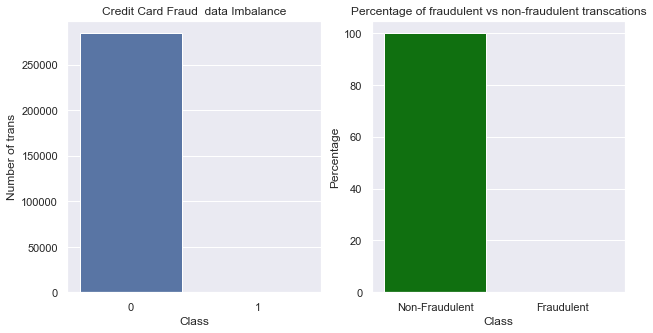

In [72]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
classes=df['Class'].value_counts()
NonFraud=round(classes[0]/df['Class'].count()*100,2)
fraud=round(classes[1]/df['Class'].count()*100, 2)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(df["Class"])
plt.ylabel("Number of trans")
plt.xlabel("Class")
plt.title("Credit Card Fraud  data Imbalance")

plt.subplot(1,2,2)
fraud_percentage = {'Class':['Non-Fraudulent', 'Fraudulent'], 'Percentage':[NonFraud, fraud]} 
df_fraud_percentage = pd.DataFrame(fraud_percentage) 
sns.barplot(x='Class',y='Percentage', data=df_fraud_percentage, color='green')
plt.title('Percentage of fraudulent vs non-fraudulent transcations')

plt.show()

## Observation:

There is signficant amount of class imbalance

In [73]:
# Finding the initial full correlation in the dataset:

# correlation matrix
cor = df.corr()
cor

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,7.388135e-17,2.125498e-16,2.053457e-16,-2.425603e-17,-5.020280e-16,3.547782e-16,7.212815e-17,-3.879840e-16,3.230206e-17,1.502024e-16,4.654551e-16,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,-3.991394e-16,1.975426e-16,-9.568710e-17,6.295388e-16,-1.730566e-16,-4.995814e-17,1.177316e-17,-2.685296e-16,3.284605e-16,-7.118719e-18,2.506675e-16,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,1.156587e-15,1.576830e-15,6.310231e-16,2.807652e-16,4.739859e-16,9.068793e-16,8.299445e-16,7.614712e-16,1.509897e-16,3.463522e-16,-9.316409e-16,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,2.232685e-16,3.459380e-16,-5.625518e-16,1.303306e-16,2.282280e-16,1.377649e-16,-9.614528e-16,-2.699612e-16,-5.103644e-16,-3.980557e-16,-1.857247e-16,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,-5.202306e-16,7.203963e-16,7.412552e-16,5.886991e-16,6.565143e-16,-8.720275e-16,2.246261e-15,1.281914e-16,5.308590e-16,-1.450421e-16,-3.554057e-16,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,5.932243e-17,1.980503e-15,2.375468e-16,-1.211182e-16,2.621312e-16,-1.531188e-15,2.623672e-18,2.015618e-16,1.223814e-16,-1.865597e-16,-1.858755e-16,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,-7.492834e-17,1.425248e-16,-3.536655e-18,1.266462e-17,2.607772e-16,-1.690540e-16,5.869302e-17,2.177192e-16,7.604126e-17,-1.881008e-16,9.379684e-16,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,-2.801370e-16,2.487043e-16,1.839891e-16,-2.921856e-16,-8.599156e-16,4.127777e-16,-5.254741e-16,-2.269549e-16,-3.667974e-16,-3.875186e-16,2.033737e-16,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,-4.642274e-16,1.354680e-16,-1.079314e-15,2.251072e-15,3.784757e-15,

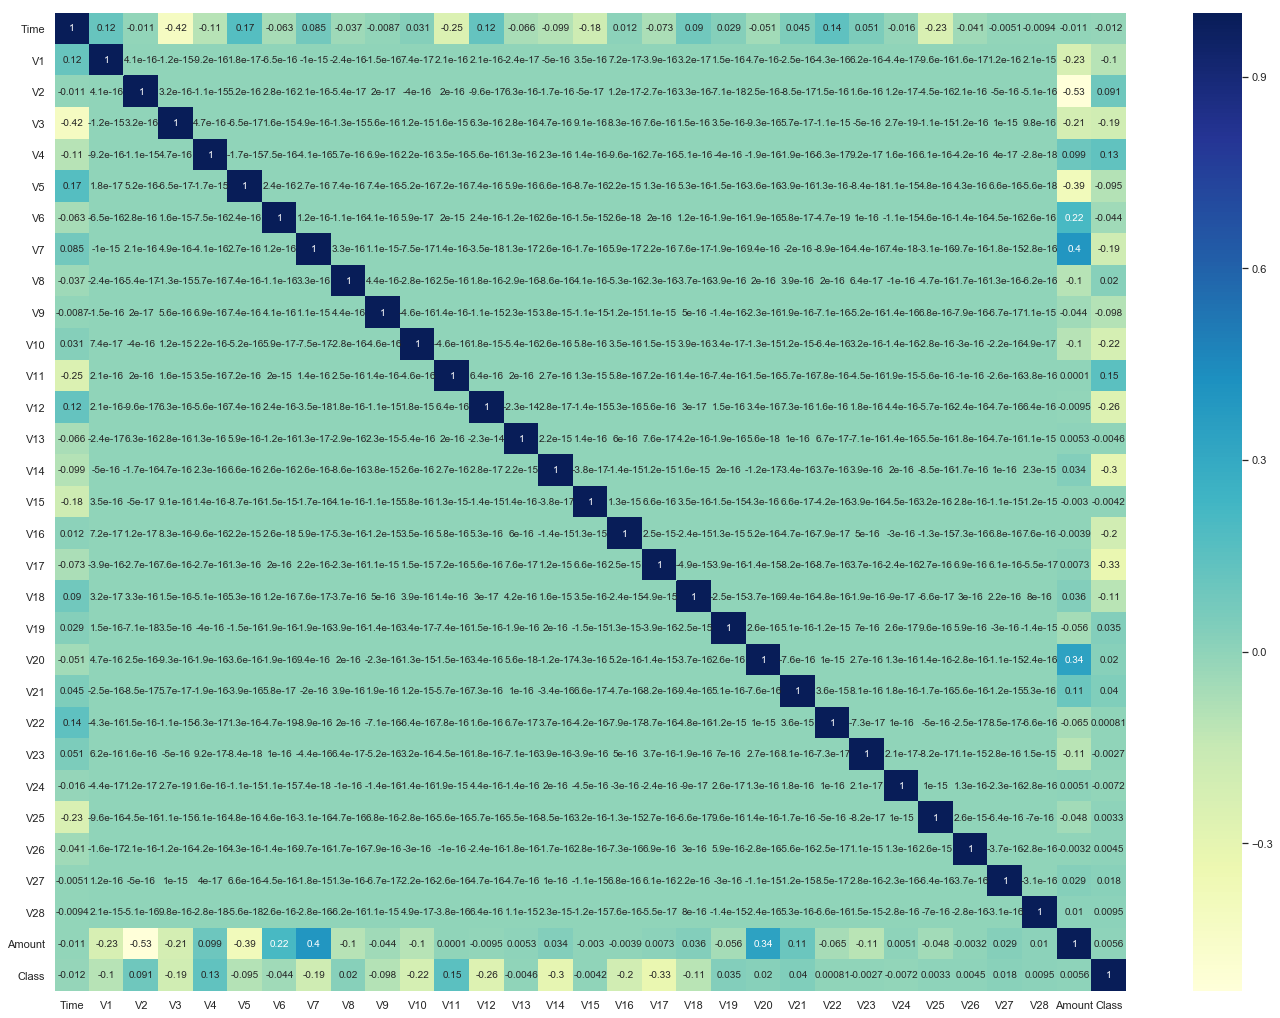

In [74]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(24,18))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

## Observation:

No significant corellation between variables

## Performing UniVariant/ Bi Variant Analysis

In [75]:
# Create a scatter plot to observe the distribution of classes with time
#As time is given in relative fashion, we will need to use pandas.Timedelta which Represents a duration, the difference between two dates or times.

Delta_Time = pd.to_timedelta(df['Time'], unit='s')
#Create derived columns Mins and hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

Text(0.5, 1.05, 'Time vs Class Distribution')

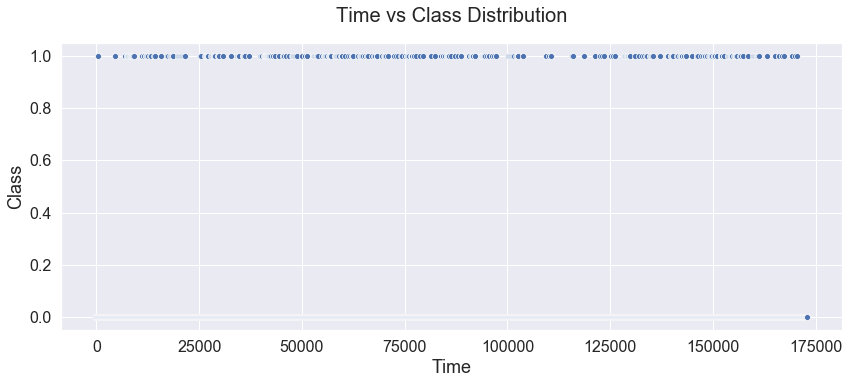

In [76]:
# Bivariate Analysis: Create a scatter plot to observe the distribution of classes with time

fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set2')

# PLot the relation between the variables:

plt.subplot(3,1,1)
sns.scatterplot(x=df['Time'], y='Class', palette=cmap, data=df)
plt.xlabel('Time', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Time vs Class Distribution', size=20, y=1.05)

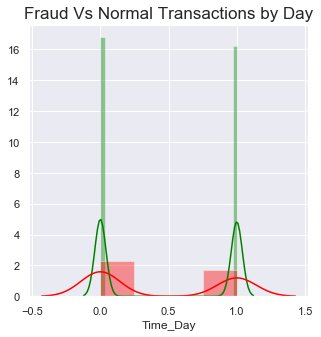

In [77]:
#The fraus Vs normal trasaction by day
plt.figure(figsize=(5,5))
sns.distplot(df[df['Class'] == 0]["Time_Day"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Day"], color='red')
plt.title('Fraud Vs Normal Transactions by Day', fontsize=17)
plt.show()

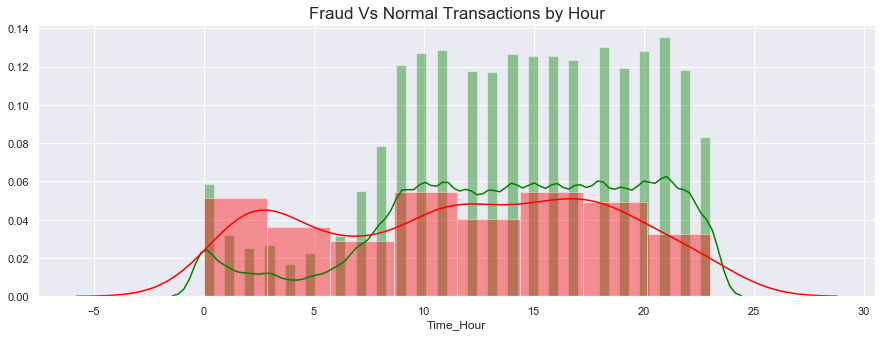

In [78]:
#The fraus Vs normal trasaction by hour
plt.figure(figsize=(15,5))
sns.distplot(df[df['Class'] == 0]["Time_Hour"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Hour"], color='red')
plt.title('Fraud Vs Normal Transactions by Hour', fontsize=17)
plt.show()

## Observation

There is not much insight can be drwan from the distribution of the fraudulent transaction based on time as fraudulent/non-fraudulent both transaction are distributed over time.

In [79]:
# day/minutes might not be very useful as this is not time series data, we will keep only derived column hour
df.drop(['Time_Day', 'Time_Min'], axis = 1, inplace= True)

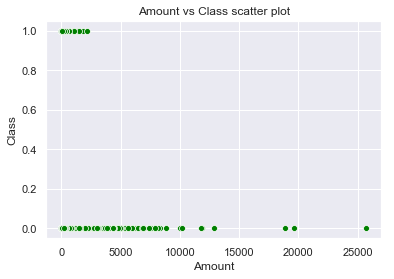

In [80]:
# Create a scatter plot to observe the distribution of classes with Amount
sns.scatterplot(df["Amount"], df["Class"], color='green')
plt.title("Amount vs Class scatter plot")
plt.show()

## Observation

Clearly low amount of transactions are more likely to be fraudulent than high amount transaction.



### Dropping Time column as this feature is not going to help in the model building.

In [81]:
# Drop unnecessary columns
df = df.drop("Time", axis = 1)

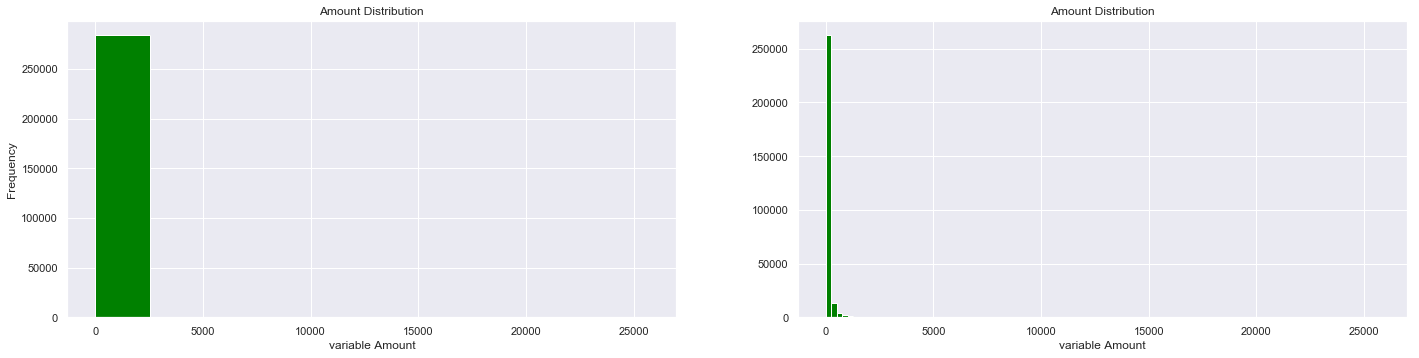

In [82]:
# Let's try to understand the Amount variable as it is not PCA transformed variable :

plt.figure(figsize=(24, 12))

plt.subplot(2,2,1)
plt.title('Amount Distribution')
df['Amount'].astype(int).plot.hist( color='green');
plt.xlabel("variable Amount")
#plt.ylabel("Frequency")

plt.subplot(2,2,2)
plt.title('Amount Distribution')
sns.set()
plt.xlabel("variable Amount")
plt.hist(df['Amount'],bins=100, color='green')
plt.show()

## Train-Test Split

In [83]:
#Create X and y dataset for independent and dependent data
y= df['Class']
X = df.drop(['Class'], axis=1)

In [84]:
# Spltting the into 80:20 train test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [85]:
# Checking the split of the class lable
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


## Feature Scaling using Standard Scaler

In [86]:
# As PCA is already performed on the dataset from V1 to V28 features, we are scaling only Amount field
scaler = StandardScaler()

# Scaling the train data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Transforming the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

In [87]:
cols = list(X.columns.values)

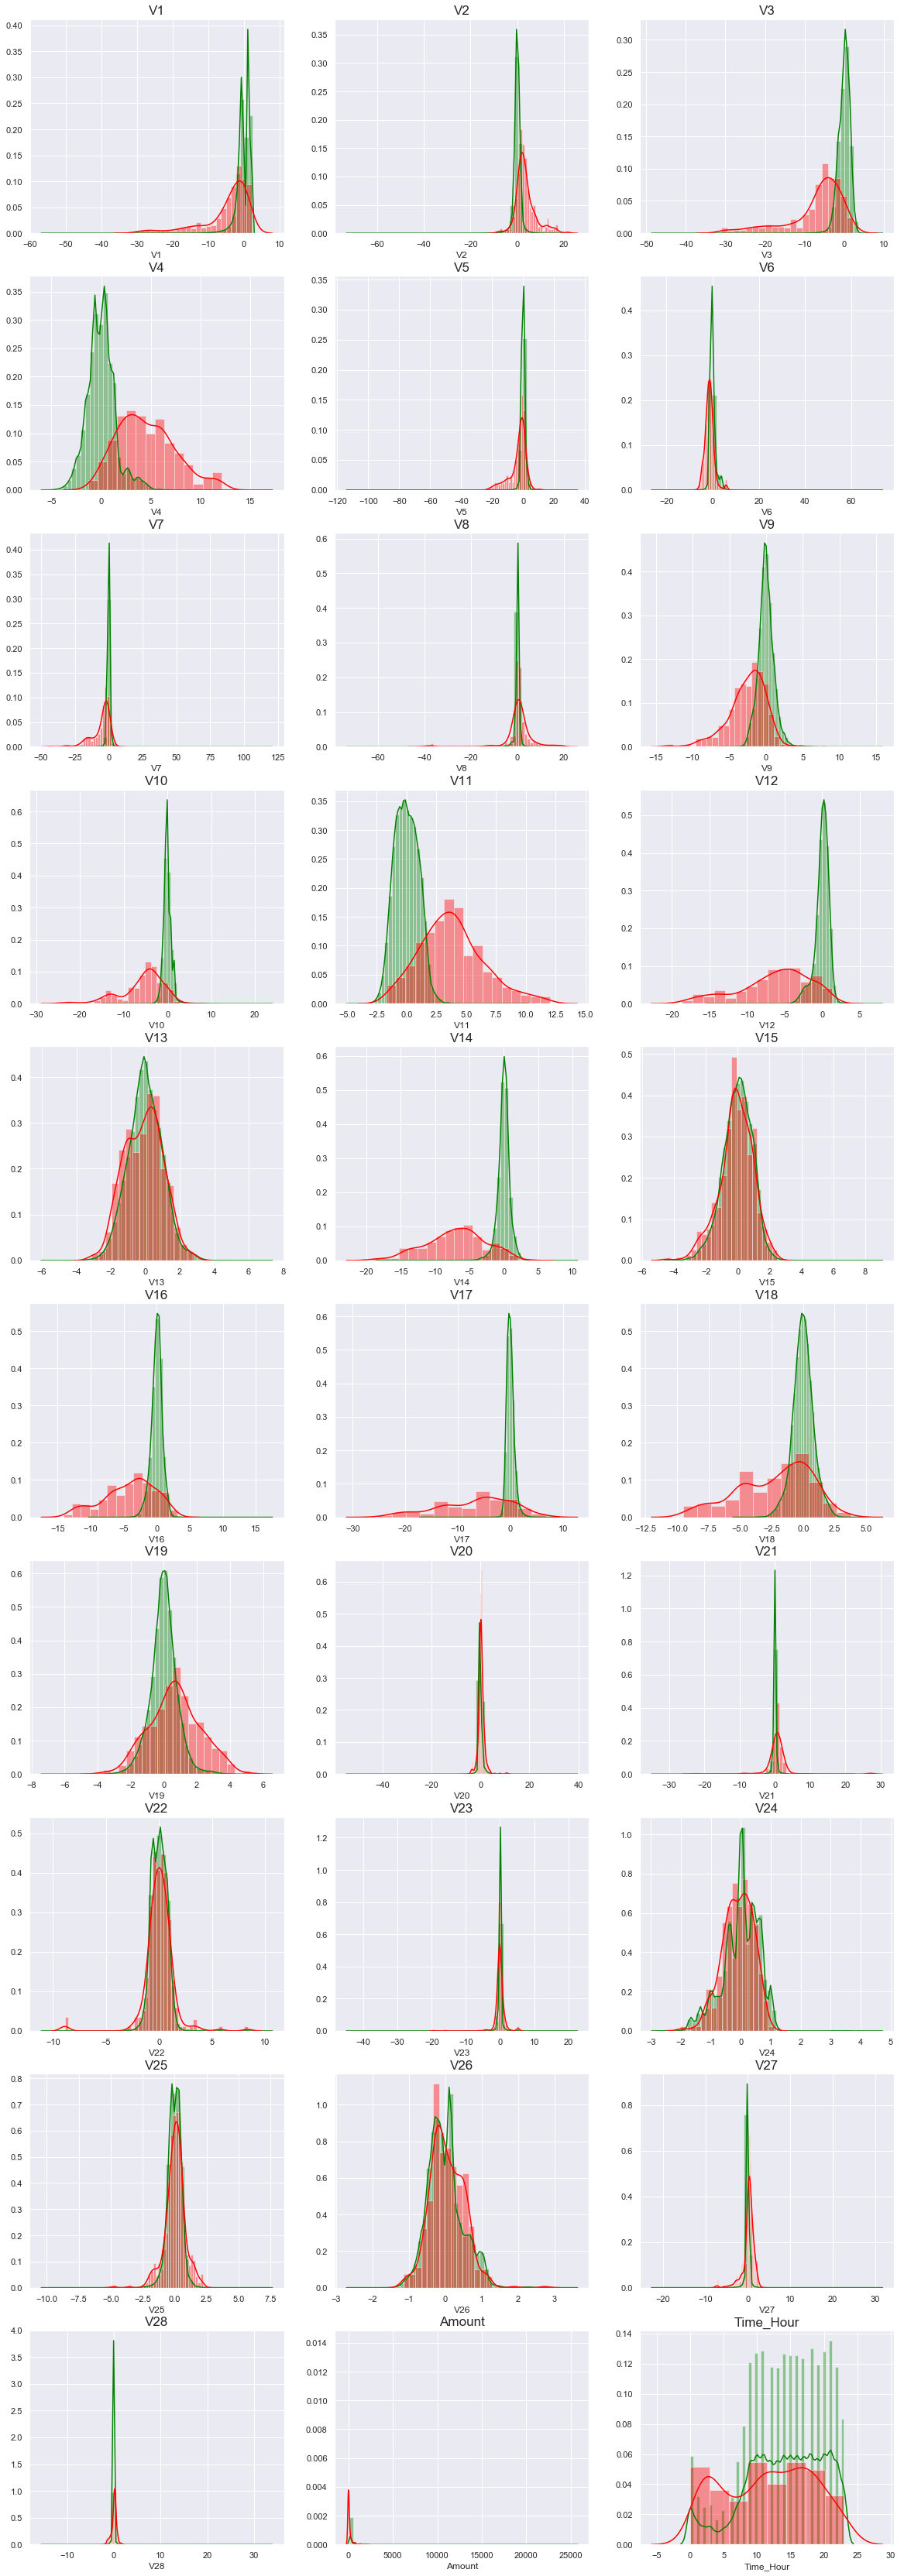

In [88]:
# plot the histogram of a variable from the dataset to see the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

## Check skewness of Features

In [89]:
# Lets check the skewness of the features
var = X_train.columns
skew_list = []
for i in var:
    skew_list.append(X_train[i].skew())

tmp = pd.concat([pd.DataFrame(var, columns=["Features"]), pd.DataFrame(skew_list, columns=["Skewness"])], axis=1)
tmp.set_index("Features", inplace=True)
tmp.T

Features,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
Skewness,-3.320269,-4.826847,-2.219375,0.677776,-2.928646,1.977725,3.74462,-8.445014,0.543603,1.212102,0.359527,-2.281334,0.067612,-1.992812,-0.308053,-1.113875,-3.975821,-0.266115,0.107289,-1.977859,3.656863,-0.230008,-6.285467,-0.552668,-0.417168,0.579265,-0.03833,11.776522,18.352356,-0.489419


In [90]:
# Filtering the features which has skewness less than -1 and greater than +1
skewed = tmp.loc[(tmp["Skewness"] > 1) | (tmp["Skewness"] <-1 )].index
print(skewed)

Index(['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16',
       'V17', 'V20', 'V21', 'V23', 'V28', 'Amount'],
      dtype='object', name='Features')


## Observations:
There is skewness present in the distribution of the above features:
Power Transformer package is used to make the distribution more gaussian

In [91]:
# preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer(copy=False)

# Fitting the power transformer in train data
X_train[skewed] = pt.fit_transform(X_train[skewed])


# Transforming the test data
X_test[skewed] = pt.transform(X_test[skewed])

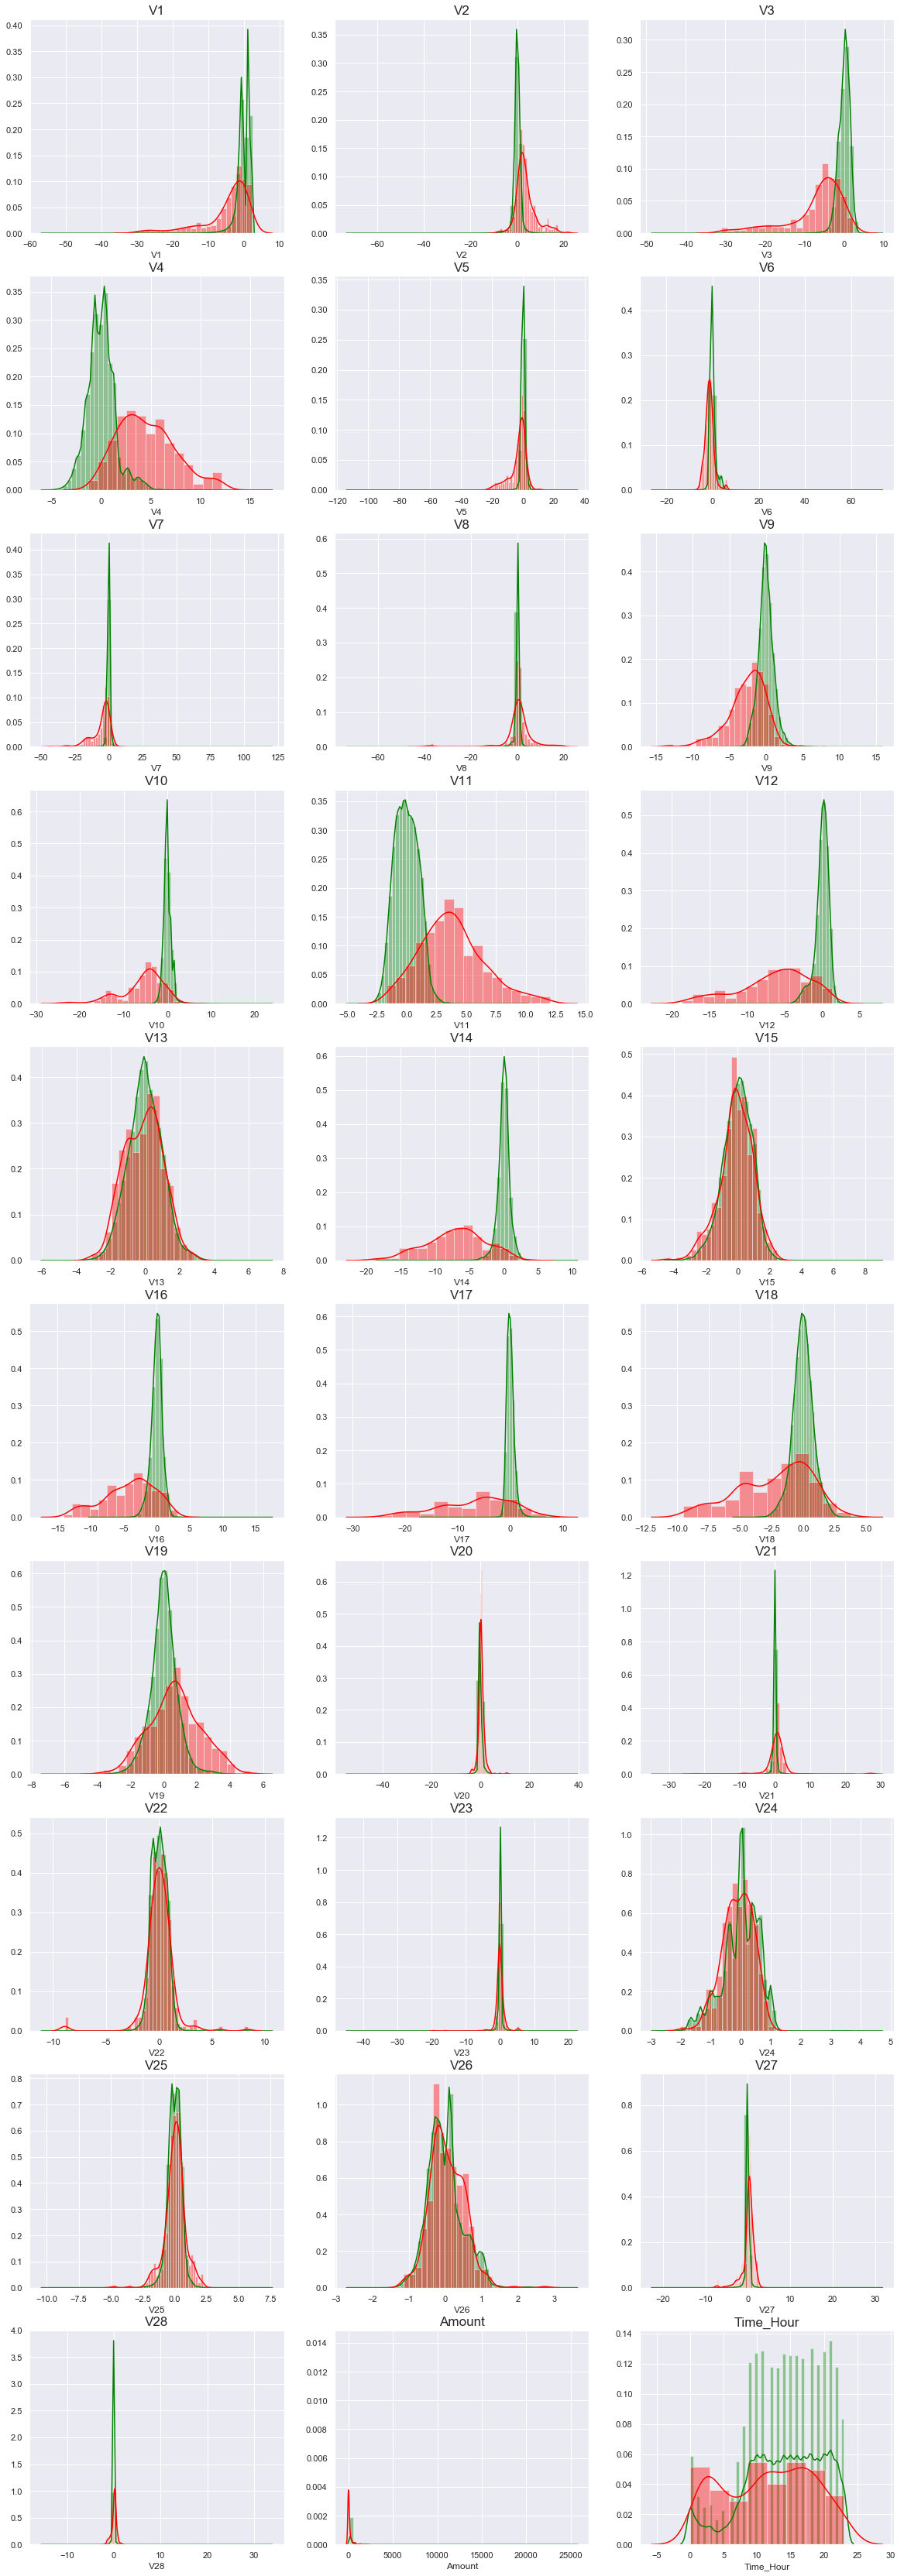

In [92]:
# plot the histogram of a variable from the dataset to see the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

## Model Building with imbalanced data
We are going to build models on below mentioned algorithms and we will compare for the best model. We are not building models on SVM, RandomForest and KNN as these algorithms are computationaly expensive and need more computational resources specially for the SVM and KNN. KNN algorithms calculate distance between each data points and then this calculation iterates for all the data points to calcualte the nearest neighbour. This process is computationally very expensive when we have very large data set. We do not have these resource available so we are skipping these models.
- Logistic Regression - Decision Tree - XGBoost

## Metric selection on imbalance data
We are going to use ROC-AUC score as the evaluation metric for the model evaluation purpose. As the data is highly imbalanced and we have only 0.17% fraud cases in the whole data, accuracy will not be the right metric to evaluate the model.

In [93]:
#Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handiling','Model','Accuracy','roc_value','threshold'])

## Utility Functions For Model Building

In [94]:
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  classNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

In [1]:
def buildLogisticModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):

  # Logistic Regression
  from sklearn import linear_model #import the package
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )
  #searchCV.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  searchCV_l1.fit(X_train, y_train)
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_) 

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_) 


  #find predicted vallues
  y_pred_l2 = searchCV_l2.predict(X_test)
  y_pred_l1 = searchCV_l1.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  from sklearn.metrics import roc_auc_score
  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'roc_value': l2_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'roc_value': l1_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)
  return df_Results

In [2]:
def buildTreeModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate Decision Tree model with 'gini' & 'entropy'
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import roc_auc_score
  criteria = ['gini', 'entropy'] 
  scores = {} 
    
  for c in criteria: 
      dt = DecisionTreeClassifier(criterion = c, random_state=42) 
      dt.fit(X_train, y_train) 
      y_pred = dt.predict(X_test)
      test_score = dt.score(X_test, y_test) 
      tree_preds = dt.predict_proba(X_test)[:, 1]
      tree_roc_value = roc_auc_score(y_test, tree_preds)
      scores = test_score 
      print(c + " score: {0}" .format(test_score))
      print("Confusion Matrix")
      Plot_confusion_matrix(y_test, y_pred)
      print("classification Report")
      print(classification_report(y_test, y_pred))
      print(c + " tree_roc_value: {0}" .format(tree_roc_value))
      fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
      threshold = thresholds[np.argmax(tpr-fpr)]
      print("Tree threshold: {0}".format(threshold))
      roc_auc = metrics.auc(fpr, tpr)
      print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
      plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
      plt.legend(loc=4)
      plt.show()
  
      df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Tree Model with {0} criteria'.format(c),'Accuracy': test_score,'roc_value': tree_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results
      

In [3]:
def buildRandomForestModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate Random Forest model

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import roc_auc_score

  # Create the model with 100 trees
  RF_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', random_state=42)
  # Fit on training data
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('Model Accuracy: {0}'.format(RF_test_score))


  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, rf_predictions)
  print("classification Report")
  print(classification_report(y_test, rf_predictions))

  # Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print("Random Forest roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Random Forest','Accuracy': RF_test_score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [4]:
def buildXGBoostModels(df_Results, DataImabalance,X_train,y_train, X_test, y_test ):
  #Evaluate XGboost model
  from xgboost import XGBClassifier
  from sklearn.metrics import roc_auc_score
  # fit model no training data
  XGBmodel = XGBClassifier(random_state=42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))
  # Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print("XGboost roc_value: {0}" .format(XGB_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGBoost threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [5]:
def RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test):
    #Run Logistic Regression with L1 And L2 Regularisation
    import time
    print("Logistic Regression with L1 And L2 Regularisation")
    start_time = time.time()
    df_Results = buildLogisticModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test)
    print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
    print('-'*80 )
    #Run Decision Tree Models with  'gini' & 'entropy' criteria
    print("Decision Tree Models with  'gini' & 'entropy' criteria")
    start_time = time.time()
    df_Results = buildTreeModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test)
    print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
    print('-'*80 )
    #Run Random Forest Model
    print("Random Forest Model")
    start_time = time.time()
    df_Results = buildRandomForestModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test)
    print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
    print('-'*80 )
    #Run XGBoost Modela
    print("XGBoost Model")
    start_time = time.time()
    df_Results = buildXGBoostModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test)
    print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
    print('-'*80 )
    return df_Results

    

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9806633576367014
Max auc_roc for l1: 0.9776832039129305
Parameters for l2 regularisations
[[-9.45849809e-02 -2.75464695e-02 -2.29530276e-01  4.42759518e-01
   5.66271836e-02  2.88108377e-02 -1.05985248e-01 -2.26110704e-01
  -1.21111466e-01 -1.94735977e-01  1.04025867e-01 -4.57341972e-01
  -9.71011754e-02 -6.50622011e-01 -6.17363349e-02 -2.29856689e-01
  -3.86294314e-02  5.91089707e-02 -7.03359996e-02 -3.67700927e-02
   1.13422254e-01  1.55049309e-01 -7.04377373e-02  5.06758581e-03
  -5.06995132e-03  1.19685233e-04 -9.93524152e-02 -4.47877931e-02
   6.47169723e-02  4.02727186e-03]]
[-8.15577823]
{1: array([[0.97255385, 0.97255385, 0.97255385, 0.97255259, 0.97283265,
        0.97330738, 0.97959435, 0.99290424, 0.9968741 , 0.99772057,
        0.99772057, 0.99772057, 0.99772057, 0.99772057, 0.99772057,
        0.99772057, 0.99772057, 0.99772057, 0.99772057, 0.99772057],
       [0.89860348, 0.89860348, 0.89860196, 0.898

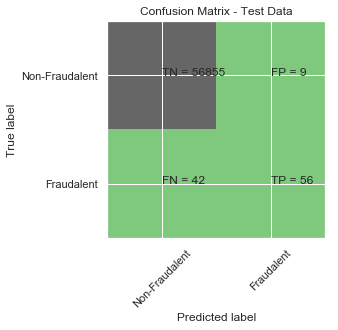

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.57      0.69        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuarcy of Logistic model with l1 regularisation : 0.9990695551420246
Confusion Matrix


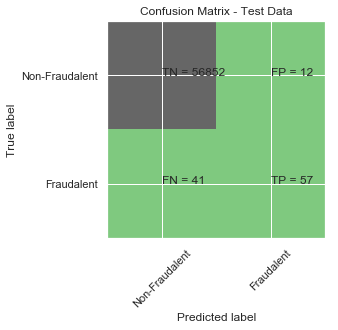

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.58      0.68        98

    accuracy                           1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.9816644510927612
l2 threshold: 0.0035089101253585444
ROC for the test dataset 98.2%


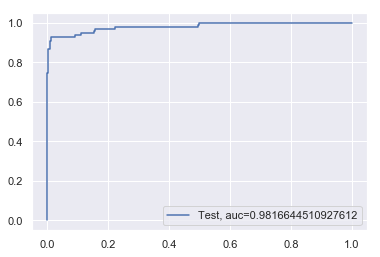

l1 roc_value: 0.928704757789441
l1 threshold: 0.02245779882163871
ROC for the test dataset 92.9%


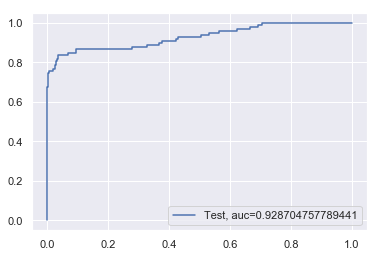

Time Taken by Model: --- 168.35115575790405 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9990695551420246
Confusion Matrix


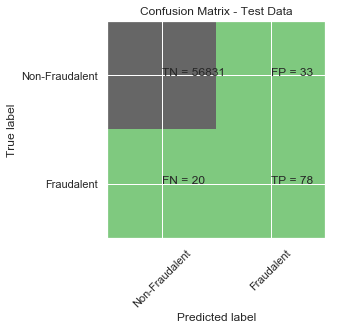

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962

gini tree_roc_value: 0.89766901766334
Tree threshold: 1.0
ROC for the test dataset 89.8%


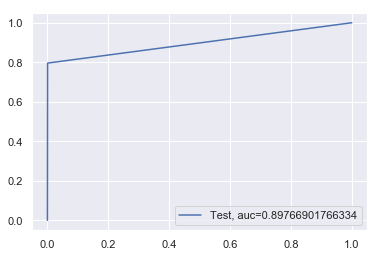

entropy score: 0.9991573329588147
Confusion Matrix


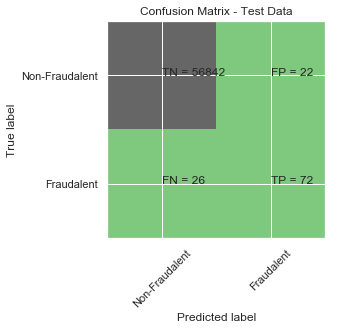

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.73      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

entropy tree_roc_value: 0.8671534947687572
Tree threshold: 1.0
ROC for the test dataset 86.7%


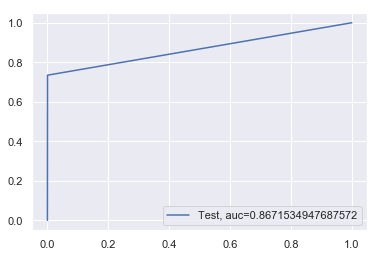

Time Taken by Model: --- 30.19863748550415 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995611109160493
Confusion Matrix


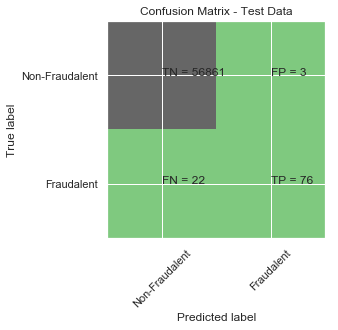

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest roc_value: 0.9627527871728321
Random Forest threshold: 0.01
ROC for the test dataset 96.3%


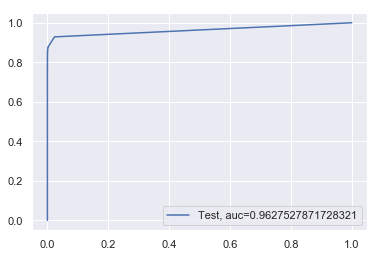

Time Taken by Model: --- 191.75614643096924 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9996137776061234
Confusion Matrix


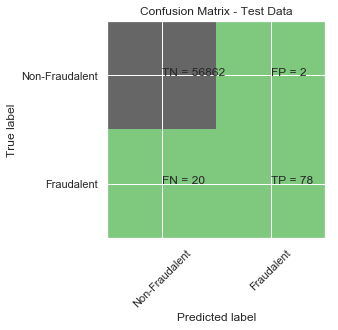

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

XGboost roc_value: 0.9823083073972414
XGBoost threshold: 7.13571353117004e-05
ROC for the test dataset 98.2%


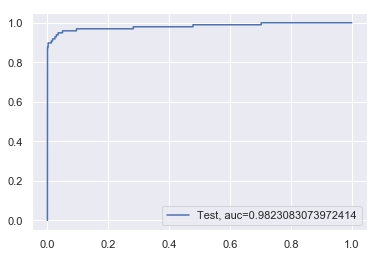

Time Taken by Model: --- 45.35373568534851 seconds ---
--------------------------------------------------------------------------------


In [100]:
Data_Imbalance_Handiling_label = "Power Transformer"
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_train,y_train, X_test, y_test)

Build different models on the imbalanced dataset and see the result

In [101]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071


## Perform cross validation with RepeatedKFold

In [102]:
#Lets perfrom RepeatedKFold and check the results
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     0      2      3 ... 284804 284805 284806] TEST: [     1      6      7 ... 284780 284782 284798]
TRAIN: [     1      2      3 ... 284803 284804 284805] TEST: [     0     10     40 ... 284796 284800 284806]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     4     12     13 ... 284781 284792 284803]
TRAIN: [     0      1      4 ... 284803 284805 284806] TEST: [     2      3      5 ... 284793 284799 284804]
TRAIN: [     0      1      2 ... 284803 284804 284806] TEST: [     9     14     24 ... 284801 284802 284805]
TRAIN: [     0      1      2 ... 284802 284804 284806] TEST: [     5      7      9 ... 284800 284803 284805]
TRAIN: [     0      1      2 ... 284803 284804 284805] TEST: [     3     11     18 ... 284792 284799 284806]
TRAIN: [     0      1      2 ... 284803 284805 284806] TEST: [     8     13     14 ... 284801 284802 284804]
TRAIN: [     1      3      5 ... 284804 284805 284806] TEST: [     0      2      4 ... 284785 284789 284796]
TRAIN: [     0     

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9812563171029403
Max auc_roc for l1: 0.9719173507728284
Parameters for l2 regularisations
[[ 6.87482212e-03  5.78191404e-02 -8.14847886e-02  2.26637281e-01
   8.58243054e-02 -4.64223621e-02 -3.71275012e-02 -1.16192587e-01
  -7.48986313e-02 -1.76934825e-01  1.39145033e-01 -2.04883409e-01
  -3.67695646e-02 -3.83810155e-01 -1.26429553e-02 -9.77797360e-02
  -8.27286271e-02 -1.04430306e-03  6.24518061e-03 -1.58487941e-02
   4.68344651e-02  2.14012495e-02 -1.73029019e-02 -1.29396747e-02
  -1.36900025e-02  3.15436797e-03 -1.21190796e-02  3.72679784e-03
   3.66145575e-04  4.53310286e-05]]
[-7.40545244]
{1: array([[0.42380487, 0.42570796, 0.45416284, 0.67948579, 0.89645598,
        0.95305917, 0.96546219, 0.97102683, 0.96634258, 0.95526883,
        0.95526883, 0.95526883, 0.95526883, 0.95526883, 0.95526883,
        0.95526883, 0.95526883, 0.95526883, 0.95526883, 0.95526883],
       [0.62225101, 0.62389943, 0.64298   , 0.784

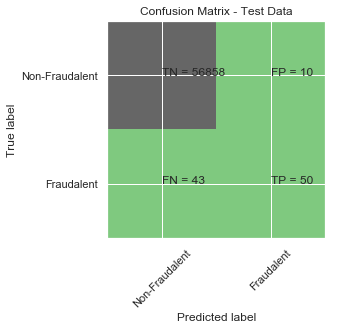

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.83      0.54      0.65        93

    accuracy                           1.00     56961
   macro avg       0.92      0.77      0.83     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9991222064219378
Confusion Matrix


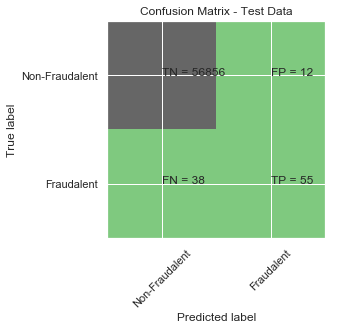

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.82      0.59      0.69        93

    accuracy                           1.00     56961
   macro avg       0.91      0.80      0.84     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9886481124747671
l2 threshold: 0.0021940348623872095
ROC for the test dataset 98.9%


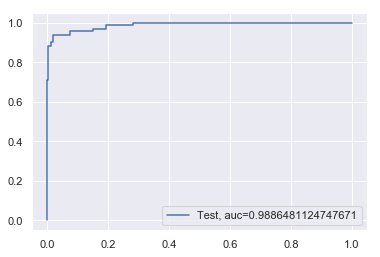

l1 roc_value: 0.8810871960798106
l1 threshold: 0.05379728932796111
ROC for the test dataset 88.1%


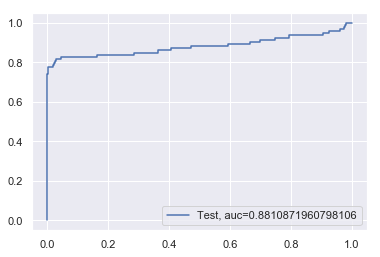

Time Taken by Model: --- 297.10589623451233 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9992099857797441
Confusion Matrix


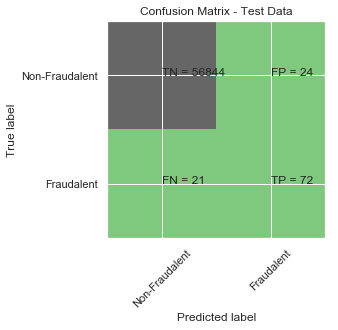

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.75      0.77      0.76        93

    accuracy                           1.00     56961
   macro avg       0.87      0.89      0.88     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8868857592114846
Tree threshold: 1.0
ROC for the test dataset 88.7%


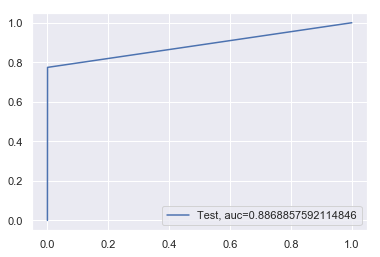

entropy score: 0.999280209265989
Confusion Matrix


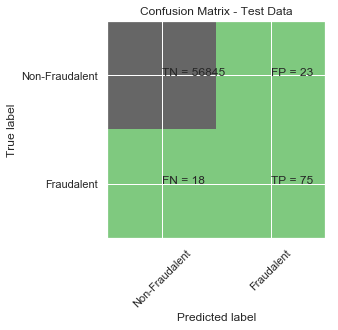

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.77      0.81      0.79        93

    accuracy                           1.00     56961
   macro avg       0.88      0.90      0.89     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.9030235837604685
Tree threshold: 1.0
ROC for the test dataset 90.3%


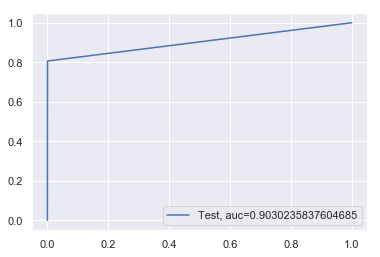

Time Taken by Model: --- 32.49428105354309 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9996839943118976
Confusion Matrix


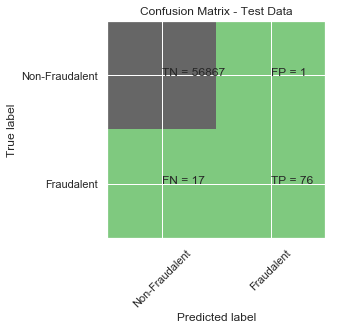

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.99      0.82      0.89        93

    accuracy                           1.00     56961
   macro avg       0.99      0.91      0.95     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.972053183338741
Random Forest threshold: 0.02
ROC for the test dataset 97.2%


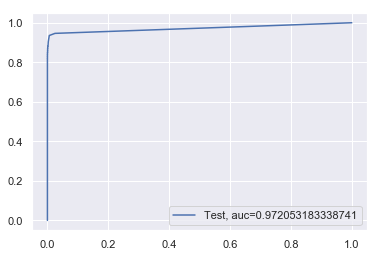

Time Taken by Model: --- 183.5309338569641 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9996839943118976
Confusion Matrix


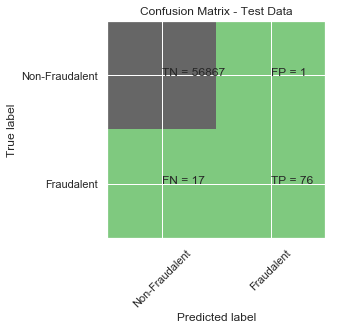

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.99      0.82      0.89        93

    accuracy                           1.00     56961
   macro avg       0.99      0.91      0.95     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9902114385246801
XGBoost threshold: 0.0001674405939411372
ROC for the test dataset 99.0%


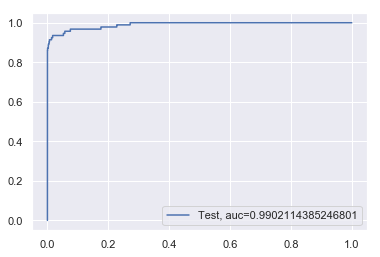

Time Taken by Model: --- 45.56858277320862 seconds ---
--------------------------------------------------------------------------------


In [103]:
Data_Imbalance_Handiling_label = "RepeatedKFold Cross Validation"
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_train_cv,y_train_cv, X_test_cv, y_test_cv)

In [104]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071
6,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.988648,0.002194
7,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999122,0.881087,0.053797
8,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999210,0.886886,1.000000
9,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.903024,1.000000


## Observation:
It seems XGBOost with Repeated KFold cross validation has provided us wih best results with ROC_Value of 0.982308 and good accuracy as well

In [105]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(random_state=42)
XGBmodel.fit(X_train_cv,y_train_cv)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(XGBmodel.feature_importances_))], axis = 1)
coefficients.columns = ['Feature','feature_importances']

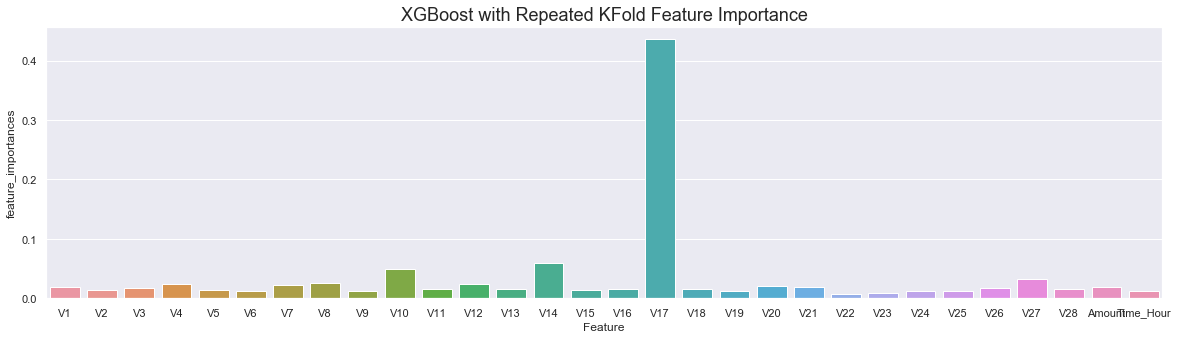

In [106]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='feature_importances', data=coefficients)
plt.title("XGBoost with Repeated KFold Feature Importance", fontsize=18)

plt.show()

## Perform cross validation with StratifiedKFold

In [107]:
#Lets perfrom StratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9825059442510036
Max auc_roc for l1: 0.9652106893977332
Parameters for l2 regularisations
[[ 0.00678175  0.06148749 -0.06701624  0.21842419  0.05403419 -0.03196176
  -0.02278856 -0.11495246 -0.06956553 -0.1636065   0.12782038 -0.1916194
  -0.03712253 -0.36064287  0.00364198 -0.0879781  -0.07286934 -0.00077004
   0.00393869 -0.02799787  0.03817793  0.02333448 -0.01168305 -0.00998198
  -0.00655181  0.00627828 -0.01017913 -0.00171354  0.00039814 -0.00084578]]
[-7.40850131]
{1: array([[0.69244071, 0.69420377, 0.71447445, 0.83769026, 0.95579724,
        0.97136042, 0.98915673, 0.99473675, 0.99128052, 0.99118357,
        0.99118357, 0.99118357, 0.99118357, 0.99118357, 0.99118357,
        0.99118357, 0.99118357, 0.99118357, 0.99118357, 0.99118357],
       [0.60700056, 0.60865399, 0.62914458, 0.76883856, 0.90900227,
        0.94879974, 0.96041026, 0.98183657, 0.98547188, 0.98327853,
        0.97955059, 0.97955059, 0.979550

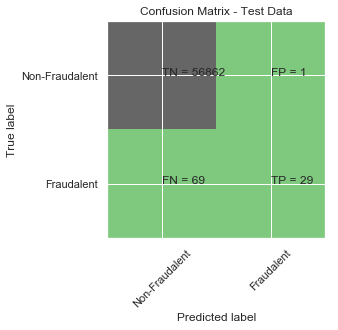

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


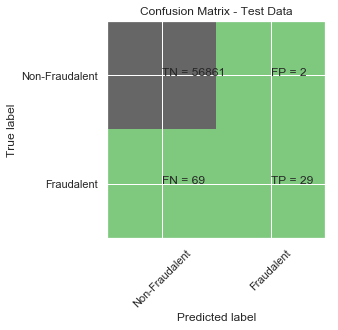

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833850568875353
l2 threshold: 0.0015551512835428106
ROC for the test dataset 98.3%


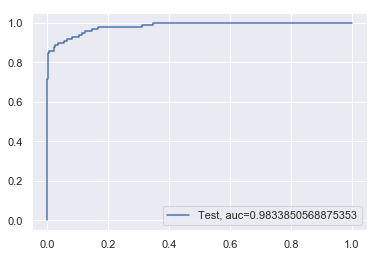

l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766199856
ROC for the test dataset 88.9%


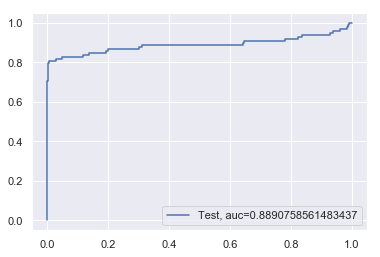

Time Taken by Model: --- 301.31817078590393 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.998841312476958
Confusion Matrix


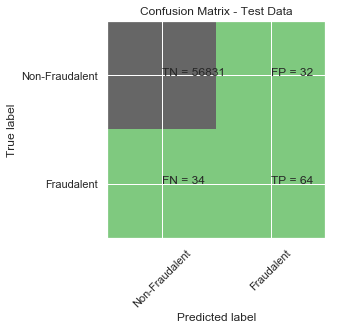

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8262492341959029
Tree threshold: 1.0
ROC for the test dataset 82.6%


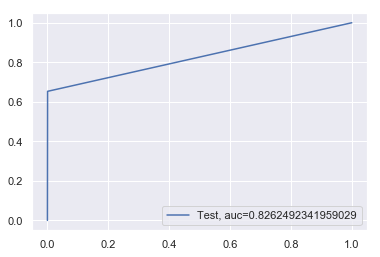

entropy score: 0.9990168711925703
Confusion Matrix


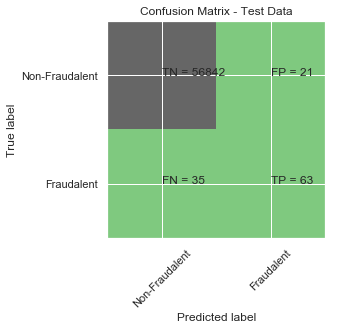

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8212439170839185
Tree threshold: 1.0
ROC for the test dataset 82.1%


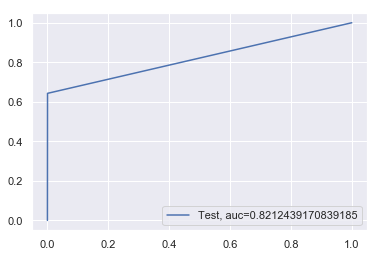

Time Taken by Model: --- 28.55599355697632 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


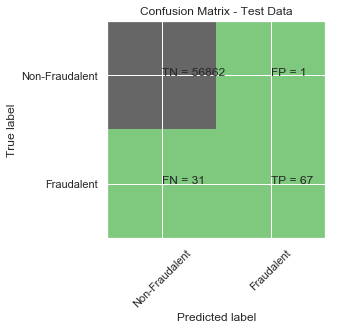

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


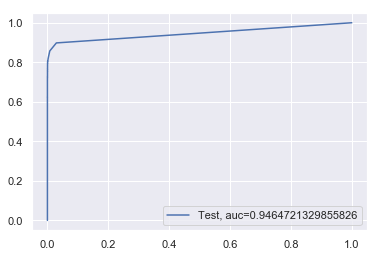

Time Taken by Model: --- 176.1113030910492 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


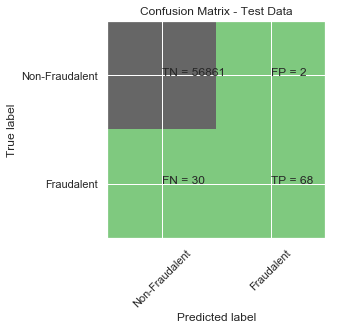

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.69      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.85      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9728122049164354
XGBoost threshold: 0.00010038168693426996
ROC for the test dataset 97.3%


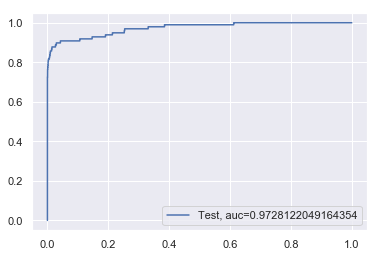

Time Taken by Model: --- 44.11083197593689 seconds ---
--------------------------------------------------------------------------------


In [108]:
Data_Imbalance_Handiling_label = "StratifiedKFold Cross Validation"
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label, X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)

In [109]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071
6,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.988648,0.002194
7,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999122,0.881087,0.053797
8,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999210,0.886886,1.000000
9,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.903024,1.000000


## Observation:
As the results show Logistic Regression with L2 Regularisation for StratifiedFold cross validation provided best results

## Proceed with the model which shows the best result
Apply the best hyperparameter on the model
Predict on the test dataset

In [110]:
 # Logistic Regression
from sklearn import linear_model #import the package
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

#searchCV.fit(X_train, y_train)
searchCV_l2.fit(X_train, y_train)
print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())


print("Parameters for l2 regularisations")
print(searchCV_l2.coef_)
print(searchCV_l2.intercept_) 
print(searchCV_l2.scores_) 


#find predicted vallues
y_pred_l2 = searchCV_l2.predict(X_test)


#Find predicted probabilities
y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)


print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))


from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print("l2 roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold))

Max auc_roc for l2: 0.9806633576367014
Parameters for l2 regularisations
[[-9.45849809e-02 -2.75464695e-02 -2.29530276e-01  4.42759518e-01
   5.66271836e-02  2.88108377e-02 -1.05985248e-01 -2.26110704e-01
  -1.21111466e-01 -1.94735977e-01  1.04025867e-01 -4.57341972e-01
  -9.71011754e-02 -6.50622011e-01 -6.17363349e-02 -2.29856689e-01
  -3.86294314e-02  5.91089707e-02 -7.03359996e-02 -3.67700927e-02
   1.13422254e-01  1.55049309e-01 -7.04377373e-02  5.06758581e-03
  -5.06995132e-03  1.19685233e-04 -9.93524152e-02 -4.47877931e-02
   6.47169723e-02  4.02727186e-03]]
[-8.15577823]
{1: array([[0.97255385, 0.97255385, 0.97255385, 0.97255259, 0.97283265,
        0.97330738, 0.97959435, 0.99290424, 0.9968741 , 0.99772057,
        0.99772057, 0.99772057, 0.99772057, 0.99772057, 0.99772057,
        0.99772057, 0.99772057, 0.99772057, 0.99772057, 0.99772057],
       [0.89860348, 0.89860348, 0.89860196, 0.89860651, 0.89934902,
        0.90117953, 0.93177851, 0.96095005, 0.96261842, 0.9569117 ,
  

In [111]:
searchCV_l2.coef_

array([[-9.45849809e-02, -2.75464695e-02, -2.29530276e-01,
         4.42759518e-01,  5.66271836e-02,  2.88108377e-02,
        -1.05985248e-01, -2.26110704e-01, -1.21111466e-01,
        -1.94735977e-01,  1.04025867e-01, -4.57341972e-01,
        -9.71011754e-02, -6.50622011e-01, -6.17363349e-02,
        -2.29856689e-01, -3.86294314e-02,  5.91089707e-02,
        -7.03359996e-02, -3.67700927e-02,  1.13422254e-01,
         1.55049309e-01, -7.04377373e-02,  5.06758581e-03,
        -5.06995132e-03,  1.19685233e-04, -9.93524152e-02,
        -4.47877931e-02,  6.47169723e-02,  4.02727186e-03]])

In [112]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(searchCV_l2.coef_))], axis = 1)
coefficients.columns = ['Feature','Importance Coefficient']

In [113]:
coefficients

,Feature,Importance Coefficient
0,V1,-0.094585
1,V2,-0.027546
2,V3,-0.229530
3,V4,0.442760
4,V5,0.056627
5,V6,0.028811
6,V7,-0.105985
7,V8,-0.226111
8,V9,-0.121111
9,V10,-0.194736


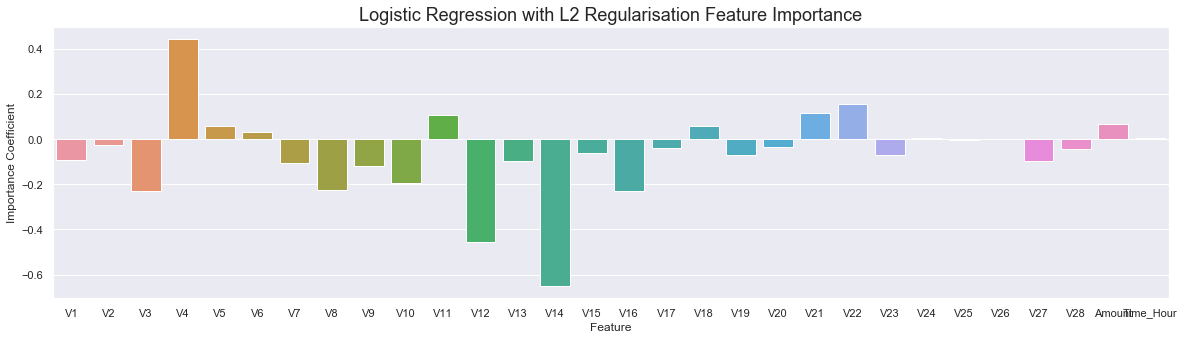

In [114]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Importance Coefficient', data=coefficients)
plt.title("Logistic Regression with L2 Regularisation Feature Importance", fontsize=18)

plt.show()

## Observation:
V4, V11, v5 has + ve imporatnce whereas V14, V12, V16 seems to have -ve impact on the predictaions

As the models Oversampling data, take significantly longer time to run.
We will try with undersampling methods

In [115]:
# Undersampling

from imblearn.under_sampling import RandomUnderSampler
#Define Oversampler
RUS = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_Under, y_Under = RUS.fit_resample(X_train, y_train)
#Create Dataframe
X_Under = pd.DataFrame(data=X_Under,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9770150041398413
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[-0.11565232 -0.00366549 -0.24832619  0.57404336  0.05636322 -0.18198082
  -0.10574153 -0.32870339 -0.20338922 -0.39486186  0.22493201 -0.39016781
  -0.10501942 -0.538771   -0.08113713 -0.1572333   0.02638918  0.0273586
  -0.09627118 -0.01907343  0.12636076  0.15256016 -0.11152213  0.05901222
   0.02580826 -0.13223775 -0.05465038  0.09762368  0.12153724 -0.04416289]]
[-2.54324441]
{1: array([[0.91153846, 0.91153846, 0.91153846, 0.91153846, 0.91185897,
        0.91730769, 0.94807692, 0.95737179, 0.96346154, 0.96282051,
        0.95705128, 0.95705128, 0.95705128, 0.95705128, 0.95705128,
        0.95705128, 0.95705128, 0.95705128, 0.95705128, 0.95705128],
       [0.89051332, 0.89051332, 0.89051332, 0.89051332, 0.89018843,
        0.89636127, 0.93404808, 0.96393762, 0.98667966, 0.98602989,
        0.98440546, 0.98440546, 0.98440546, 0.98440546,

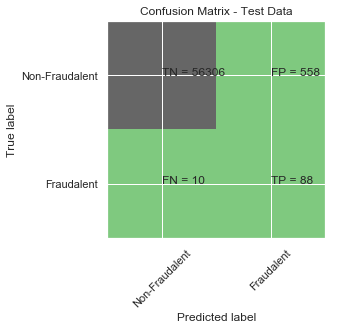

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.14      0.90      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Accuarcy of Logistic model with l1 regularisation : 0.9982795547909132
Confusion Matrix


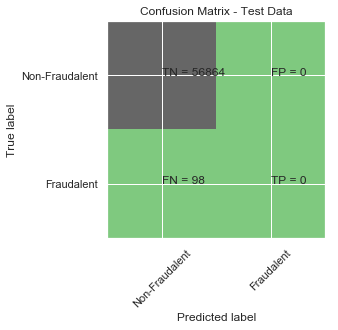

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.9832509431741182
l2 threshold: 0.406562852329511
ROC for the test dataset 98.3%


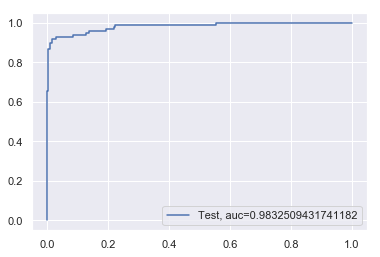

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


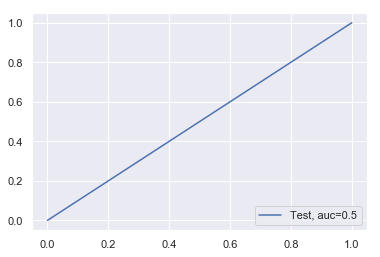

Time Taken by Model: --- 1.7279245853424072 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.935816860363049
Confusion Matrix


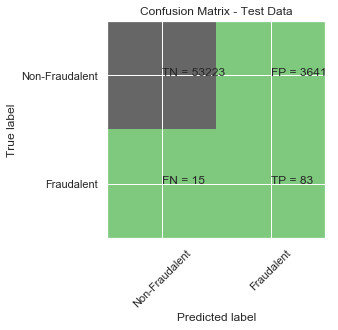

classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.85      0.04        98

    accuracy                           0.94     56962
   macro avg       0.51      0.89      0.51     56962
weighted avg       1.00      0.94      0.97     56962

gini tree_roc_value: 0.891454404637488
Tree threshold: 1.0
ROC for the test dataset 89.1%


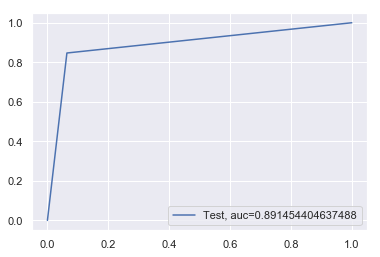

entropy score: 0.9442786419016186
Confusion Matrix


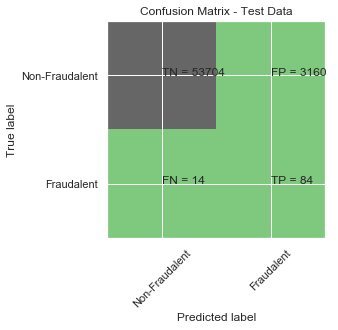

classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.86      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.94      0.97     56962

entropy tree_roc_value: 0.9007858348741861
Tree threshold: 1.0
ROC for the test dataset 90.1%


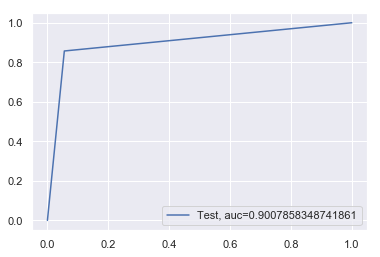

Time Taken by Model: --- 0.6585872173309326 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9927495523331343
Confusion Matrix


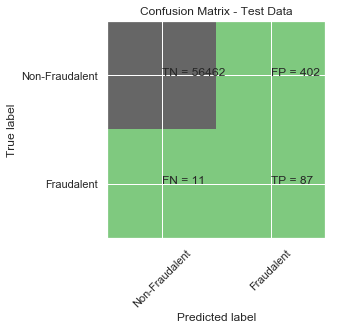

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.18      0.89      0.30        98

    accuracy                           0.99     56962
   macro avg       0.59      0.94      0.65     56962
weighted avg       1.00      0.99      1.00     56962

Random Forest roc_value: 0.9776935552639738
Random Forest threshold: 0.46
ROC for the test dataset 97.8%


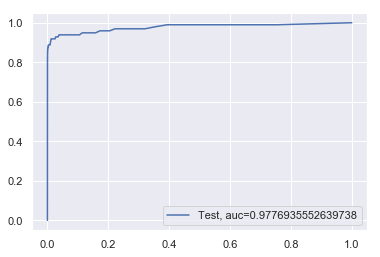

Time Taken by Model: --- 2.49566650390625 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9854113268494786
Confusion Matrix


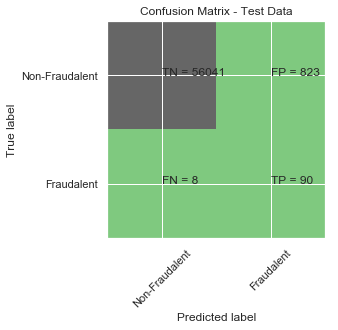

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.92      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962

XGboost roc_value: 0.9884436047913818
XGBoost threshold: 0.3434073030948639
ROC for the test dataset 98.8%


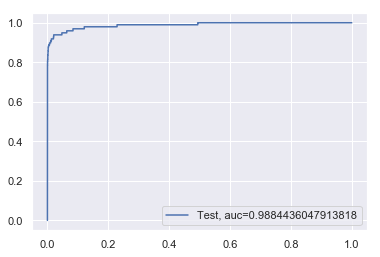

Time Taken by Model: --- 0.7522060871124268 seconds ---
--------------------------------------------------------------------------------


In [116]:
Data_Imbalance_Handiling_label = "Random Undersampling"
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_Under, y_Under , X_test, y_test)

In [117]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071
6,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.988648,0.002194
7,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999122,0.881087,0.053797
8,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999210,0.886886,1.000000
9,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.903024,1.000000


## Observations:
Seems Undersampling has impoved the XGBoost Results

## Model building with balancing Classes
Perform class balancing with :
Random Oversampling, SMOTE, ADASYN
Oversampling with StratifiedKFold Cross Validation and RandomOverSampler

Use Random Oversampling method to handle the class imbalance.

First we will display class distibution with and without the Random Oversampling.

Then We will use the oversampled with StratifiedKFold cross validation method to genearte Train And test datasets.

## Once we have train and test dataset we will feed the data to below models:

Logistic Regression with L2 Regularisation

Logistic Regression with L1 Regularisation

Decision tree model with Gini criteria

Decision tree model with Entropy criteria

Random Forest

XGBoost

We didn't try SVM (support vector Machine) model , due to extensive processive power requirement.

Once we get results for above model, we will compare the results and select model which provided best results for the Random oversampling techinique.

In [118]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over= ROS.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_over = pd.DataFrame(data=X_over,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9863447493904582
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.38459897  0.40414399  0.27732261  0.8254436   0.36438184 -0.48610213
  -0.36154347 -0.33268143 -0.21474446 -0.64516821  0.28877465 -0.92121662
  -0.30263899 -0.92040095  0.01508852 -0.53004298 -0.3080257  -0.13446561
   0.13334781 -0.71614819  0.06330767  0.54477973  0.14246965 -0.41578104
   0.21626599 -0.10928695 -0.3052214   0.18456532  0.00569949  0.04110342]]
[-5.13641071]
{1: array([[0.63721032, 0.76445945, 0.90883946, 0.95709974, 0.97767681,
        0.98502423, 0.98638158, 0.98684024, 0.98703842, 0.98710814,
        0.98711703, 0.98711703, 0.98711703, 0.98711703, 0.98711703,
        0.98711703, 0.98711703, 0.98711703, 0.98711703, 0.98711703],
       [0.63377085, 0.75995699, 0.9068891 , 0.95762962, 0.97854237,
        0.98553203, 0.98663331, 0.9869059 , 0.98708436, 0.9871491 ,
        0.98715757, 0.98715757, 0.98715757, 0.98715757

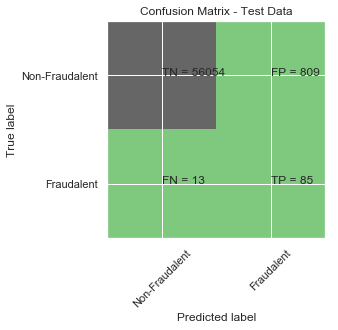

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


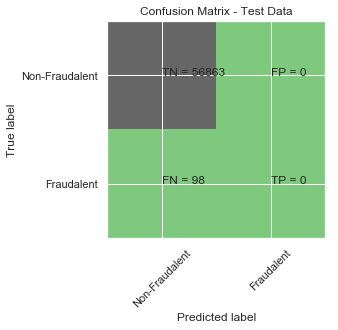

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9809120524913622
l2 threshold: 0.33574775816623903
ROC for the test dataset 98.1%


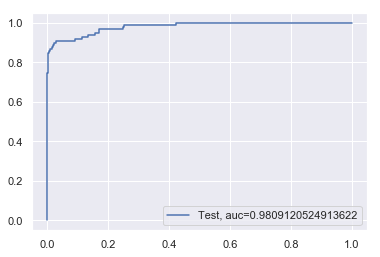

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


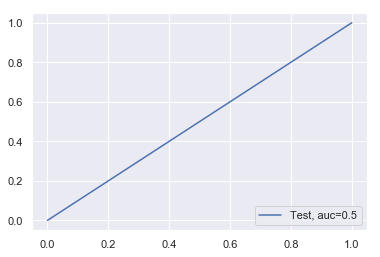

Time Taken by Model: --- 432.82498478889465 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9992099857797441
Confusion Matrix


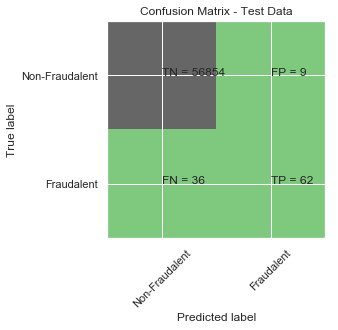

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.63      0.73        98

    accuracy                           1.00     56961
   macro avg       0.94      0.82      0.87     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8162473930359652
Tree threshold: 1.0
ROC for the test dataset 81.6%


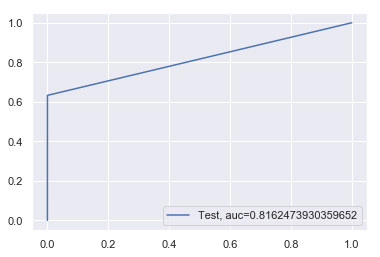

entropy score: 0.9991573181650603
Confusion Matrix


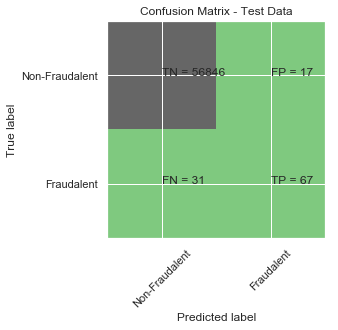

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.68      0.74        98

    accuracy                           1.00     56961
   macro avg       0.90      0.84      0.87     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.841687252605349
Tree threshold: 1.0
ROC for the test dataset 84.2%


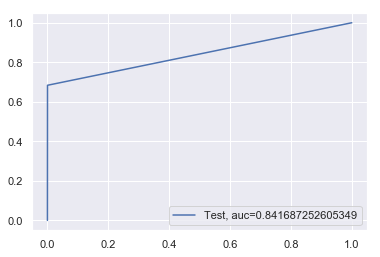

Time Taken by Model: --- 24.620378971099854 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995084355962852
Confusion Matrix


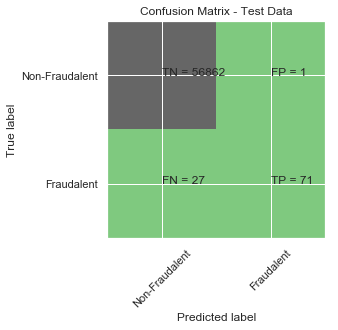

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9411583408313644
Random Forest threshold: 0.02
ROC for the test dataset 94.1%


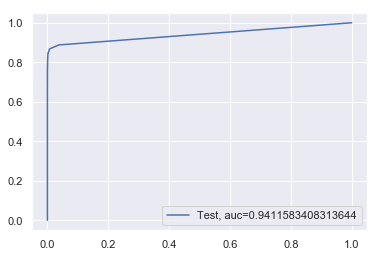

Time Taken by Model: --- 146.24694228172302 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.999490879724724
Confusion Matrix


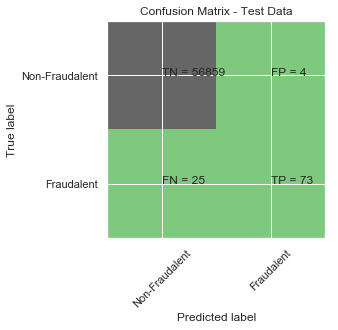

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.74      0.83        98

    accuracy                           1.00     56961
   macro avg       0.97      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9734122866739858
XGBoost threshold: 0.0010864053620025516
ROC for the test dataset 97.3%


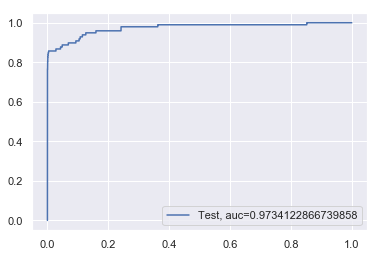

Time Taken by Model: --- 58.54299759864807 seconds ---
--------------------------------------------------------------------------------


In [119]:
Data_Imbalance_Handiling_label	 = "Random Oversampling with StratifiedKFold CV "
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_over, y_over, X_test, y_test)

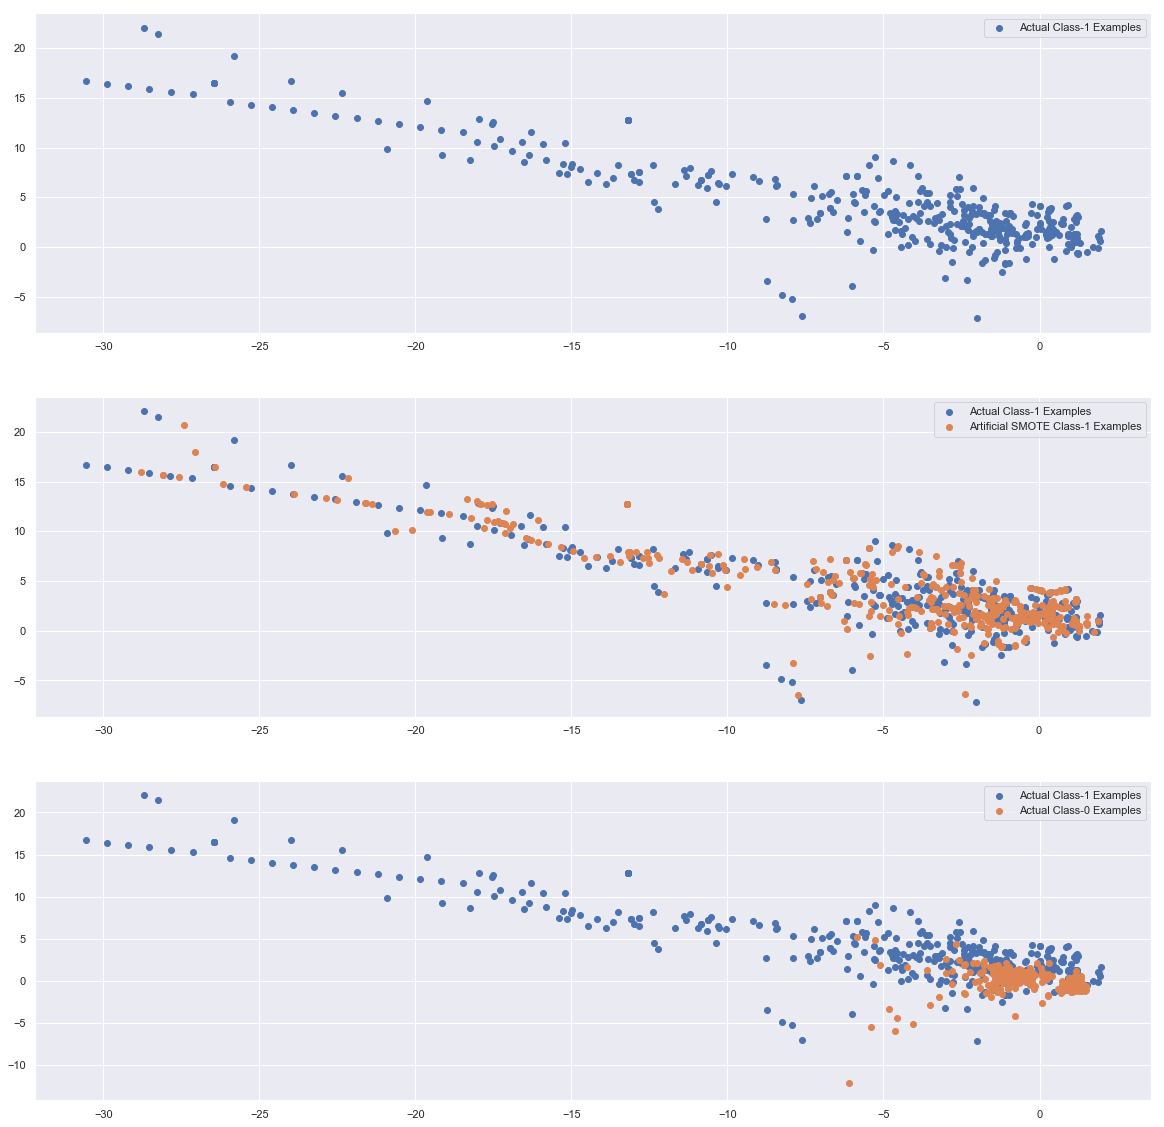

In [120]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling
SMOTE = over_sampling.SMOTE(random_state=0)

X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train) 

#Create dataframe
#X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_Smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_smote_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()


#Create dataframe
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

In [121]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9930149330105047
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.77273801  0.70956955  0.68864719  0.93847649  0.49723562 -0.93747502
  -0.69690824 -0.50685524 -0.42338666 -0.92049326  0.61716678 -1.25025097
  -0.23815563 -1.52799272  0.12549677 -0.78228055 -0.84379141 -0.43412839
   0.22170261 -1.08363026 -0.02365935  0.56541146  0.40548713 -0.91685777
   0.50619197  0.03381151 -0.18161952  0.8488871   0.0090387   0.01103523]]
[-5.30068607]
{1: array([[0.64927751, 0.78559745, 0.91748425, 0.96520455, 0.98466299,
        0.98956394, 0.99070011, 0.99160606, 0.9919527 , 0.99205284,
        0.99206918, 0.99206918, 0.99206918, 0.99206918, 0.99206918,
        0.99206918, 0.99206918, 0.99206918, 0.99206918, 0.99206918],
       [0.6460276 , 0.7845671 , 0.91904908, 0.96766048, 0.98636753,
        0.99079354, 0.99182671, 0.99273094, 0.99311438, 0.99320805,
        0.99322217, 0.99322217, 0.99322217, 0.99322217

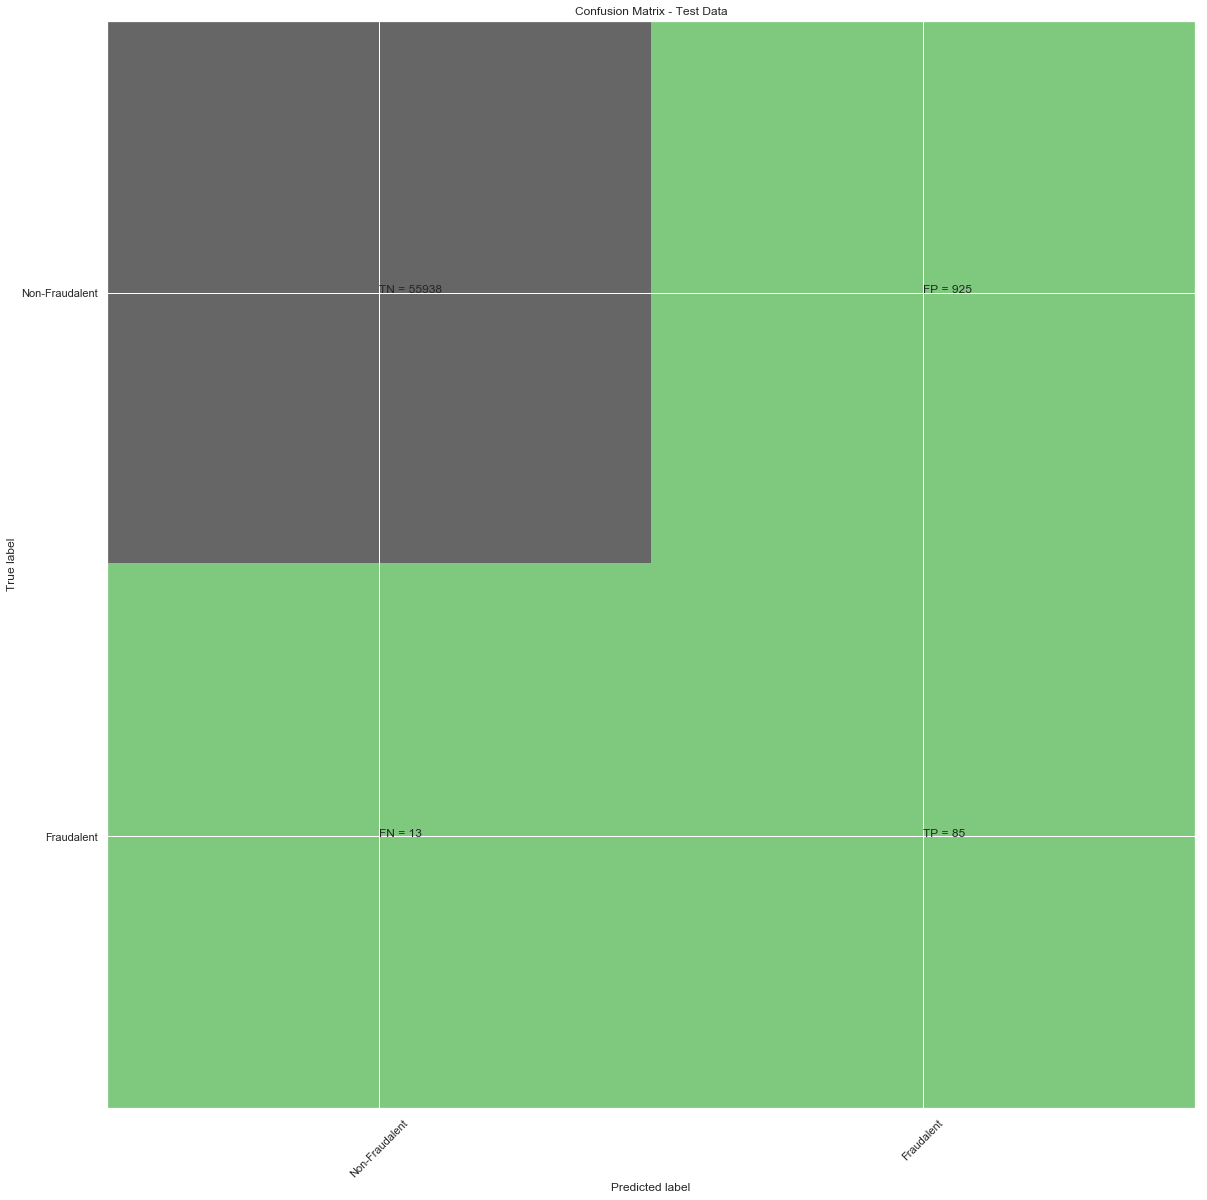

classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


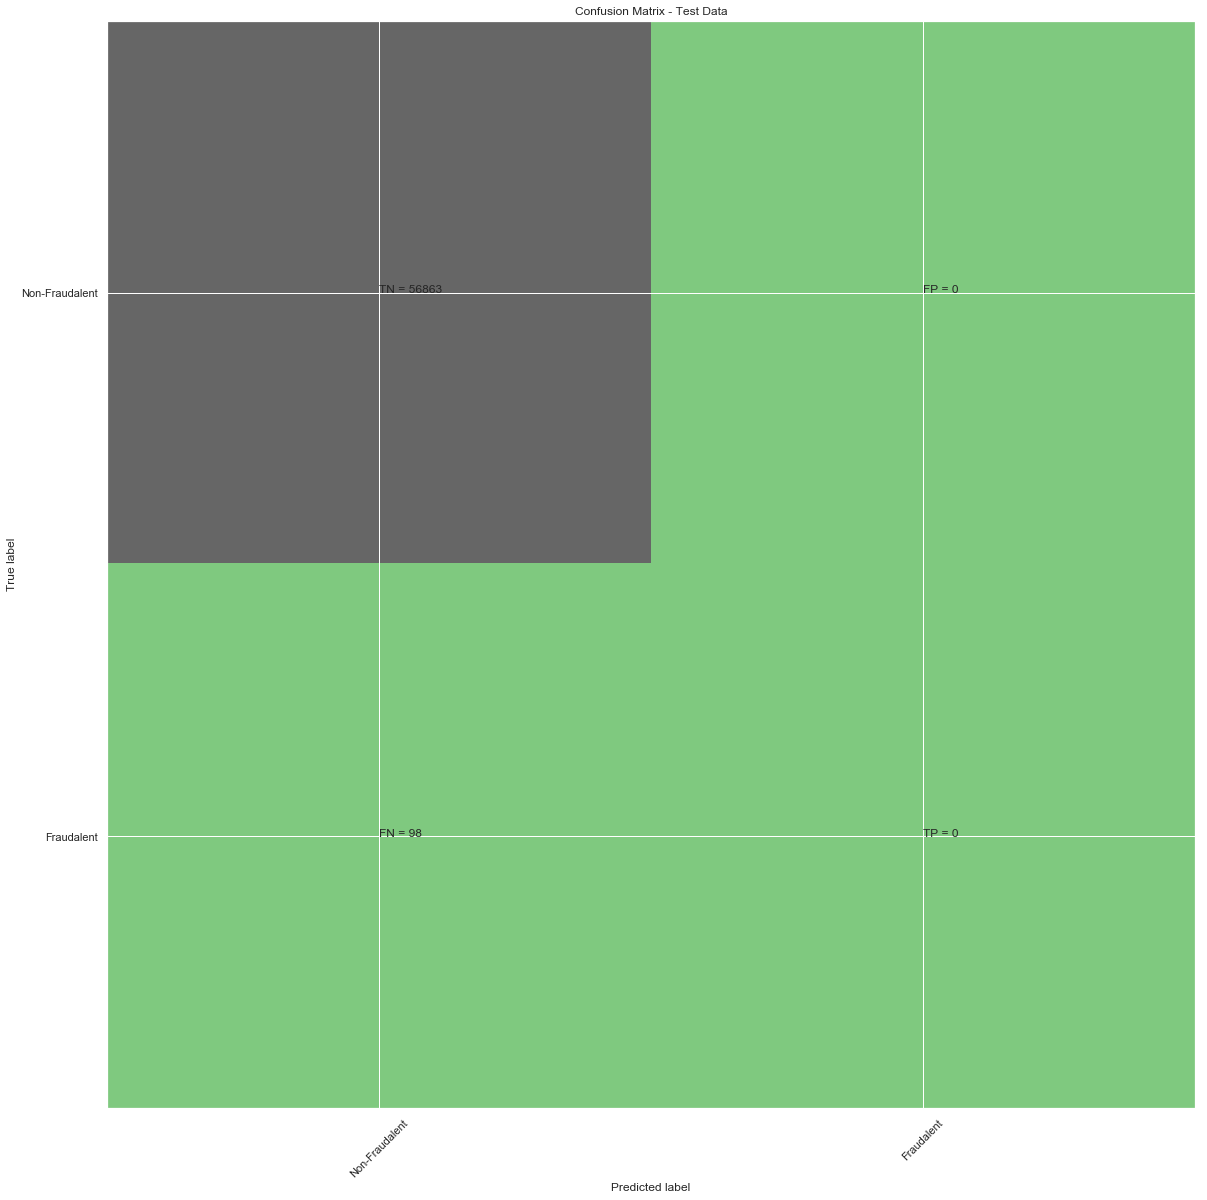

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9745891216518614
l2 threshold: 0.3941134633425972
ROC for the test dataset 97.5%


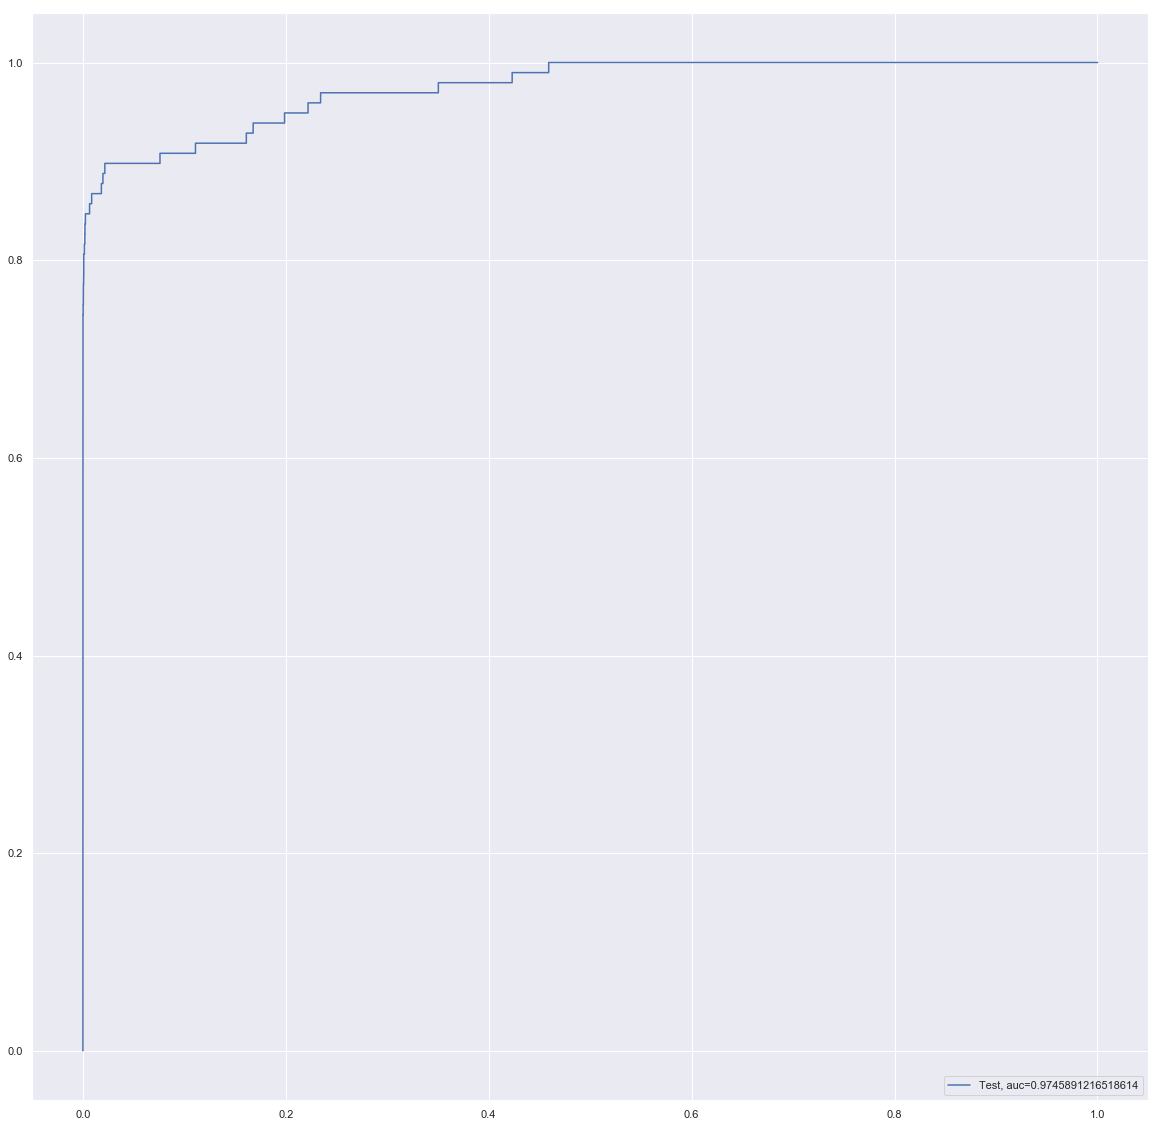

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


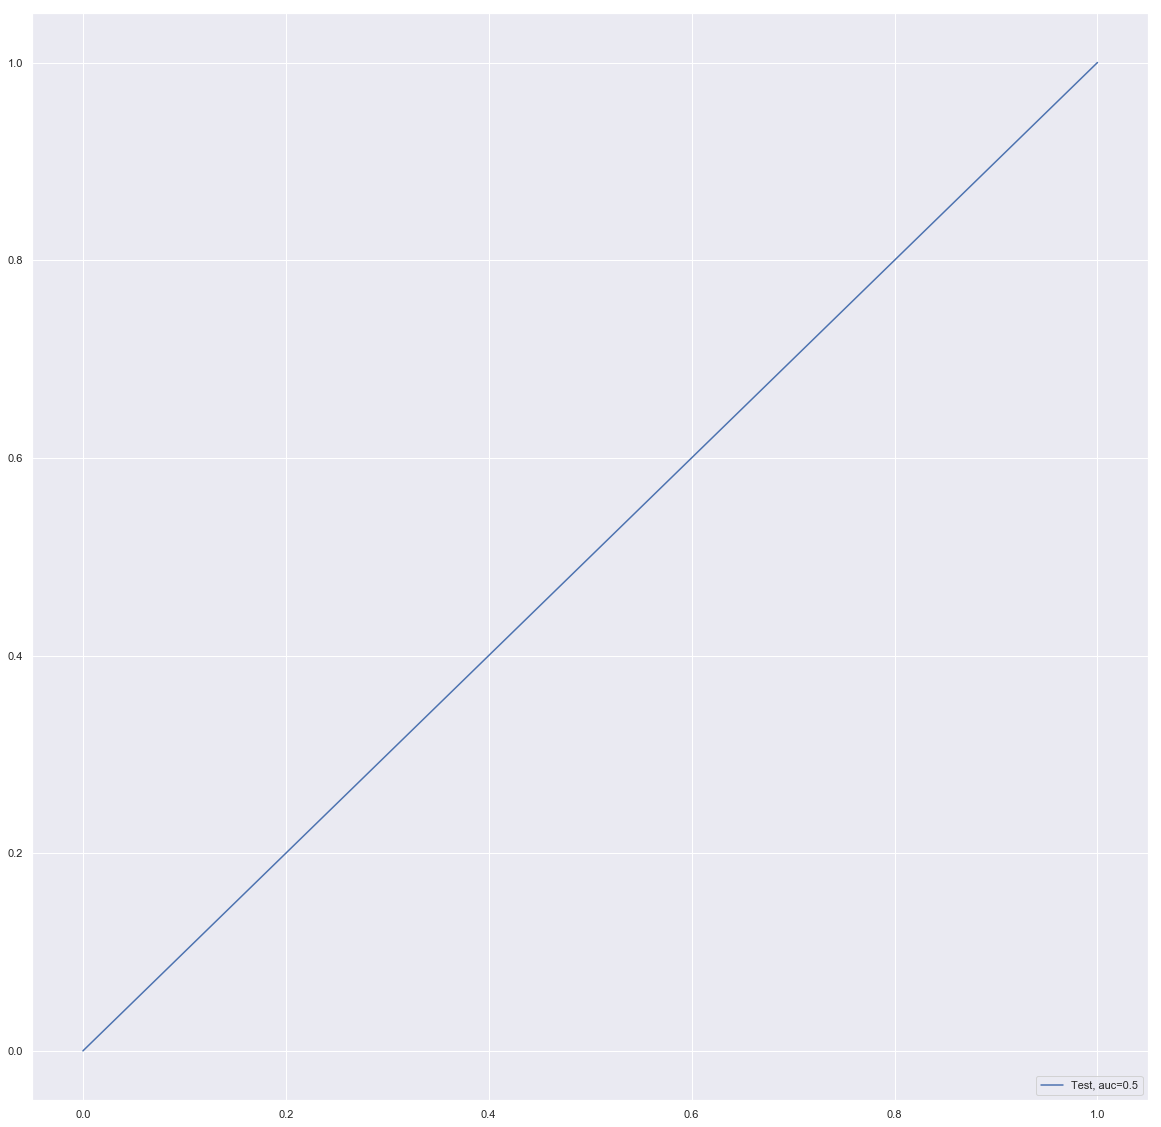

Time Taken by Model: --- 539.2455122470856 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9977528484401608
Confusion Matrix


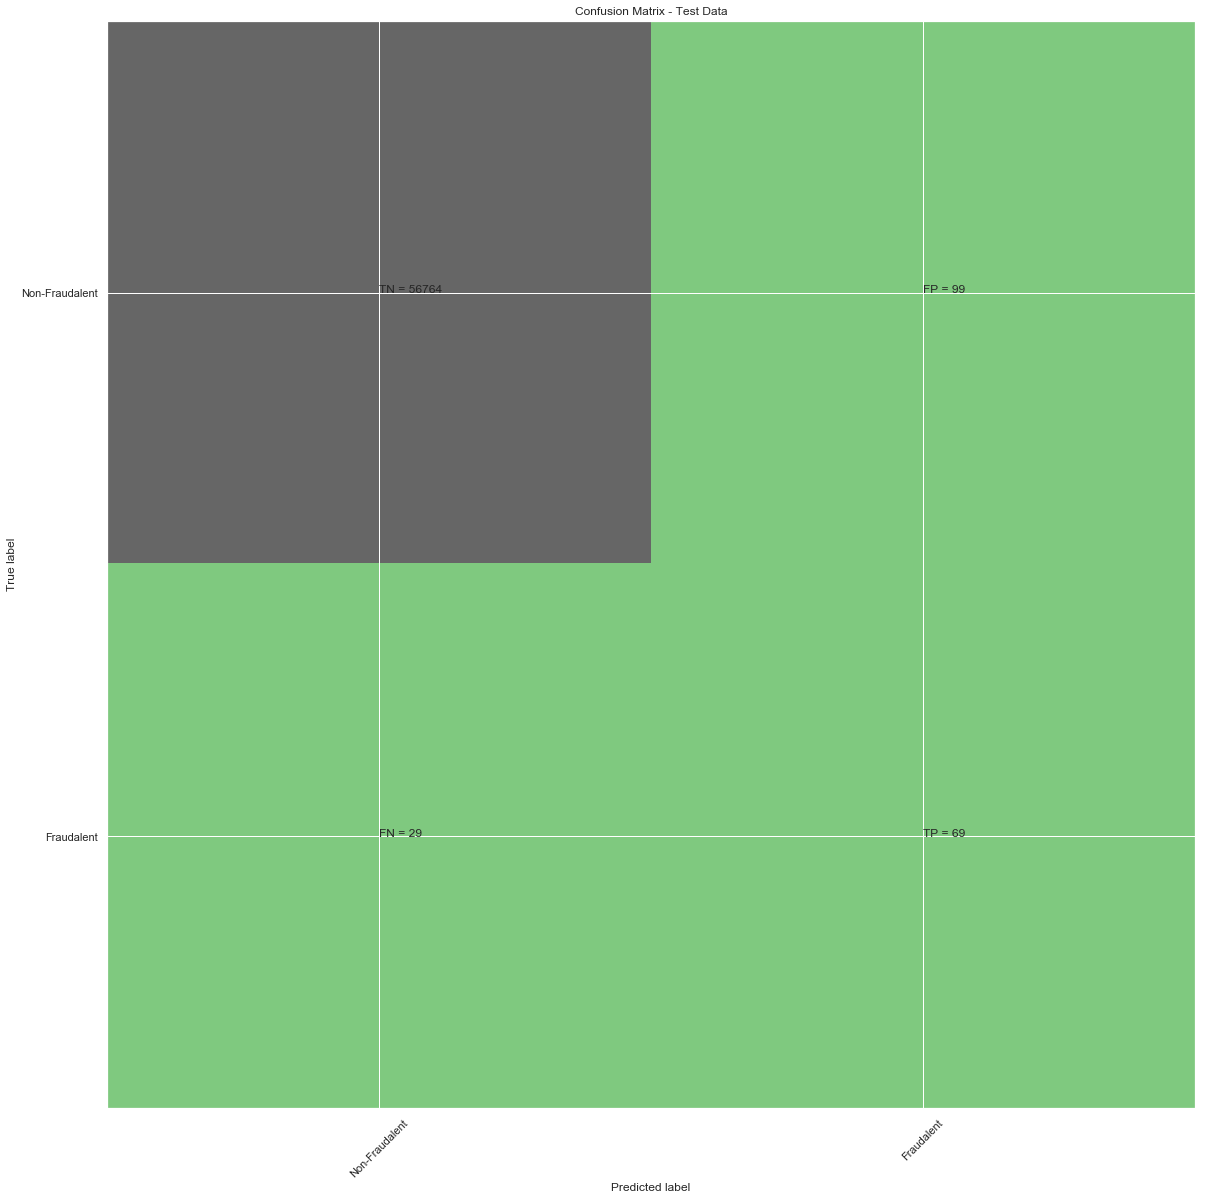

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1.0
ROC for the test dataset 85.1%


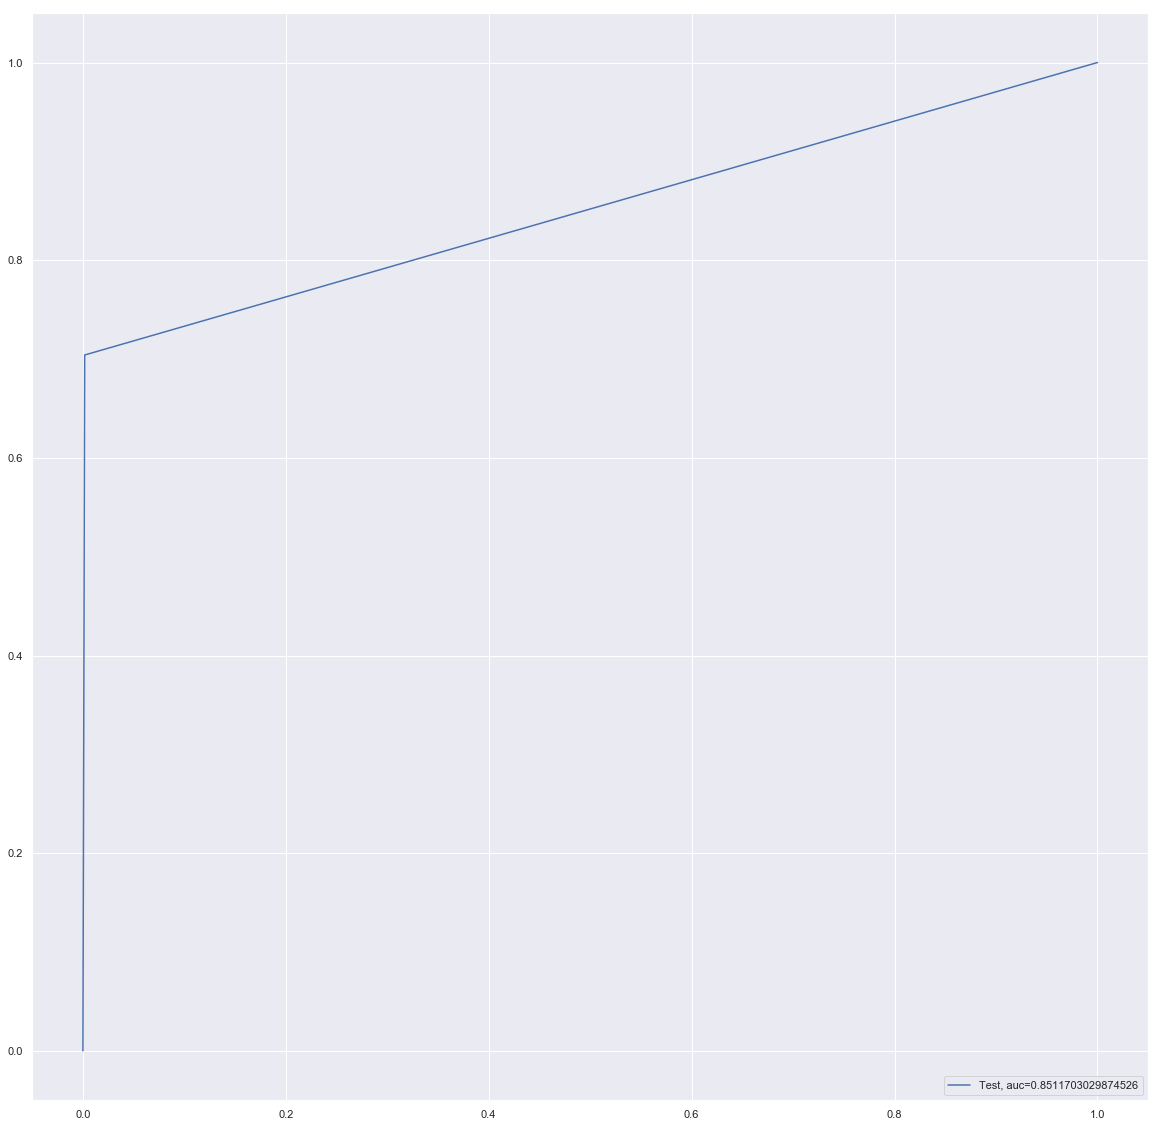

entropy score: 0.9969803900914661
Confusion Matrix


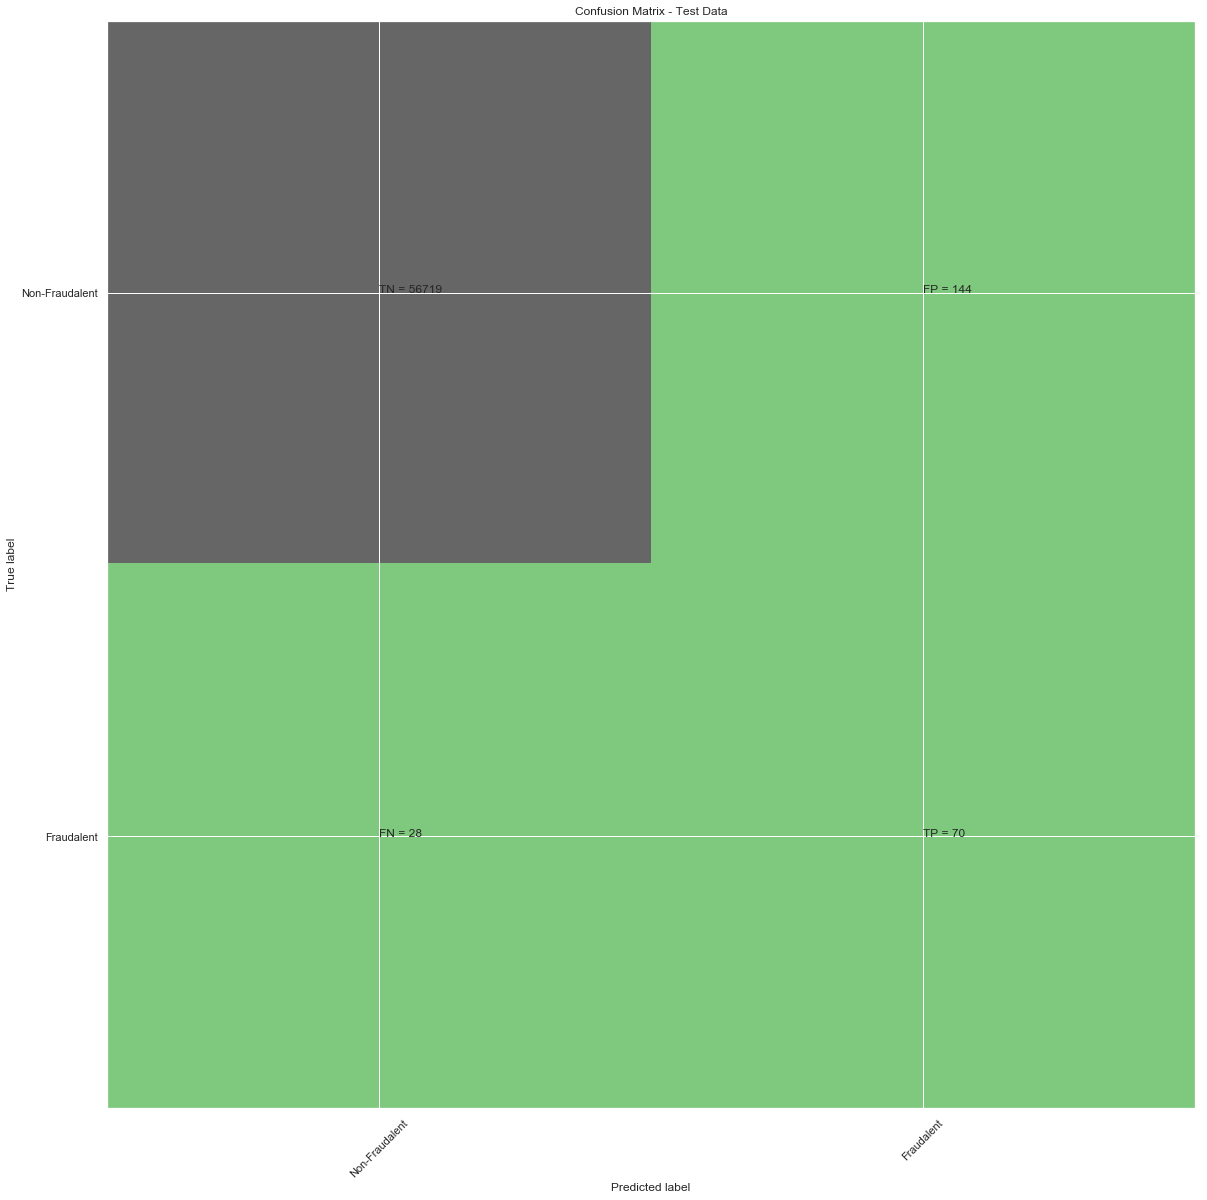

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1.0
ROC for the test dataset 85.6%


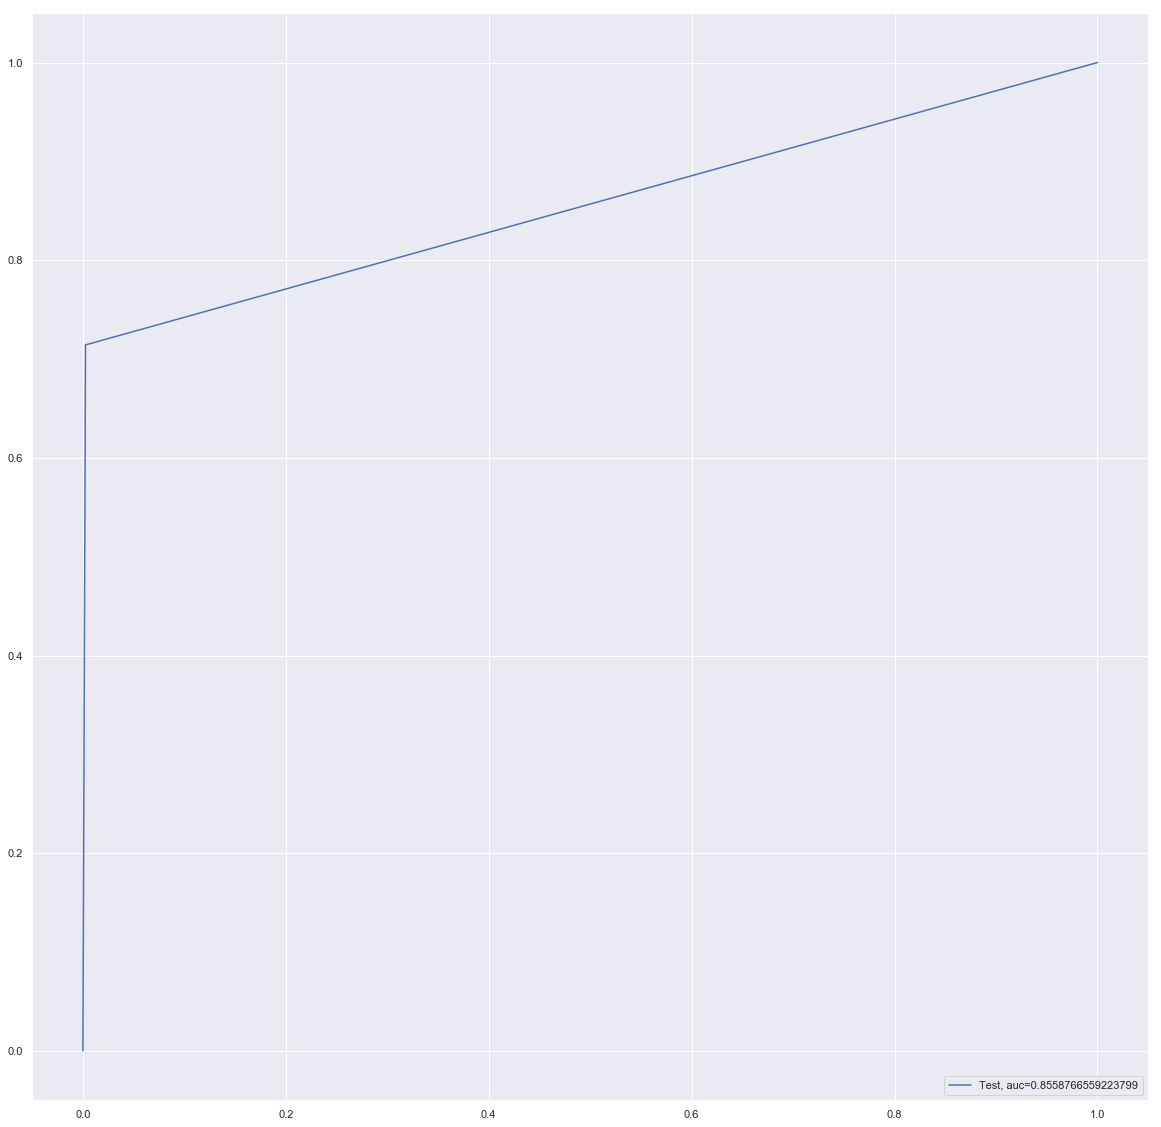

Time Taken by Model: --- 66.9403007030487 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


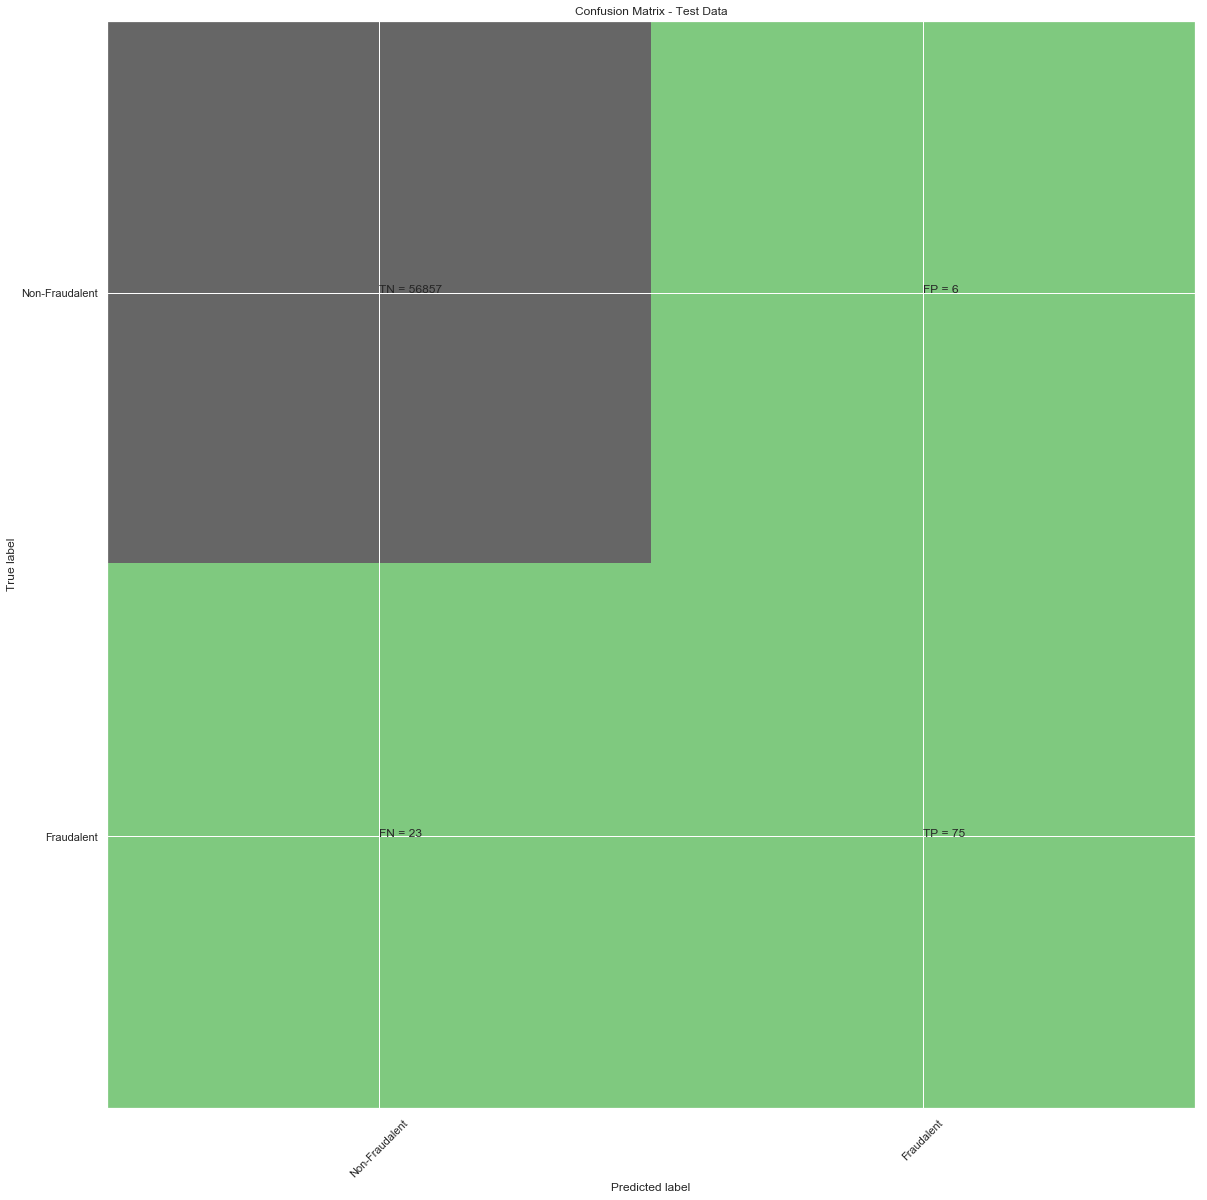

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset 96.1%


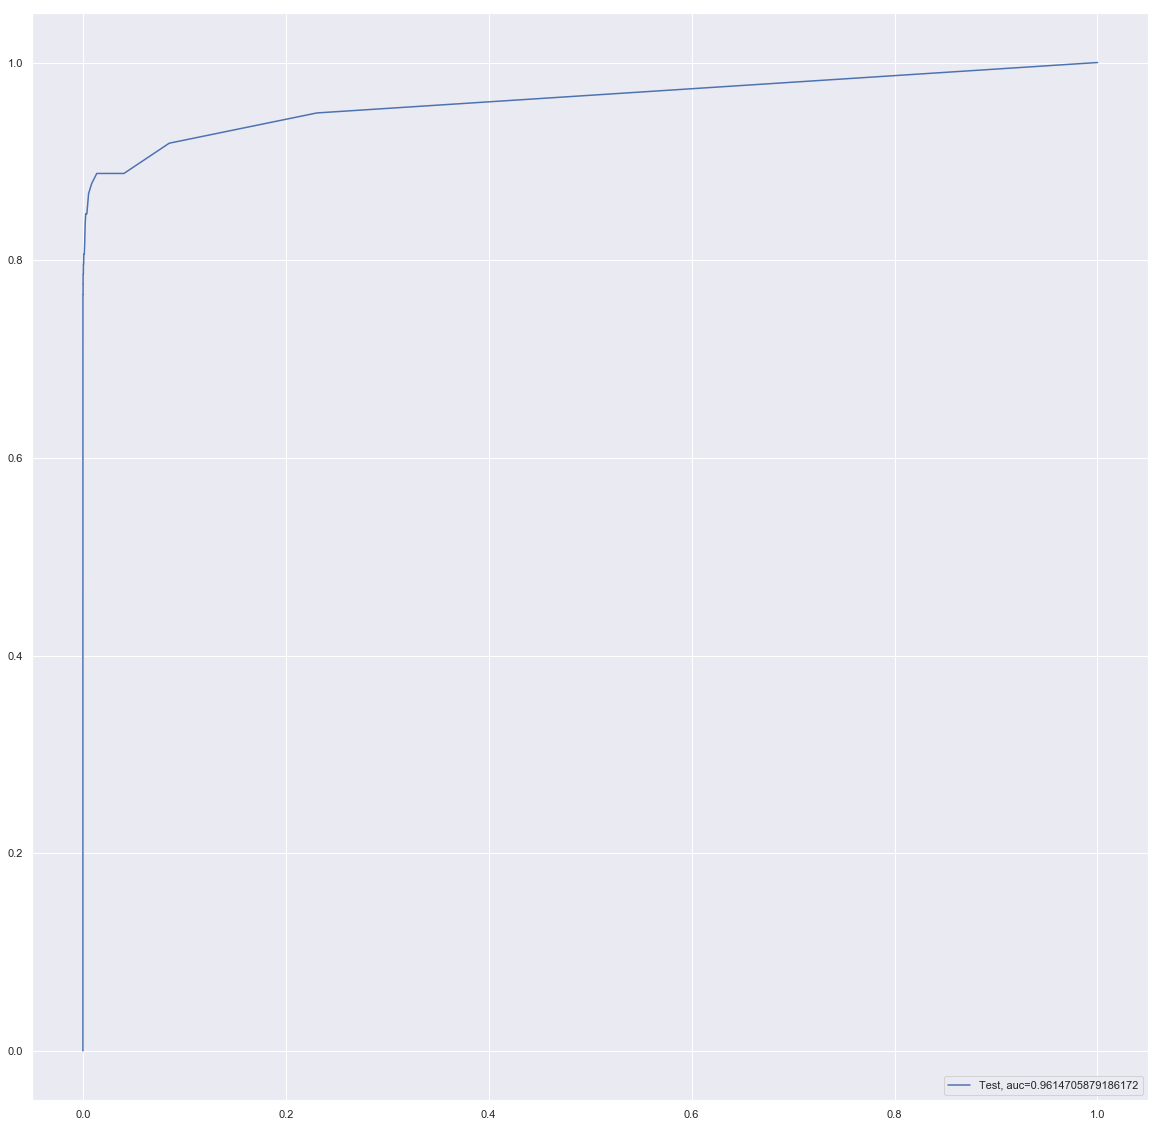

Time Taken by Model: --- 317.508820772171 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


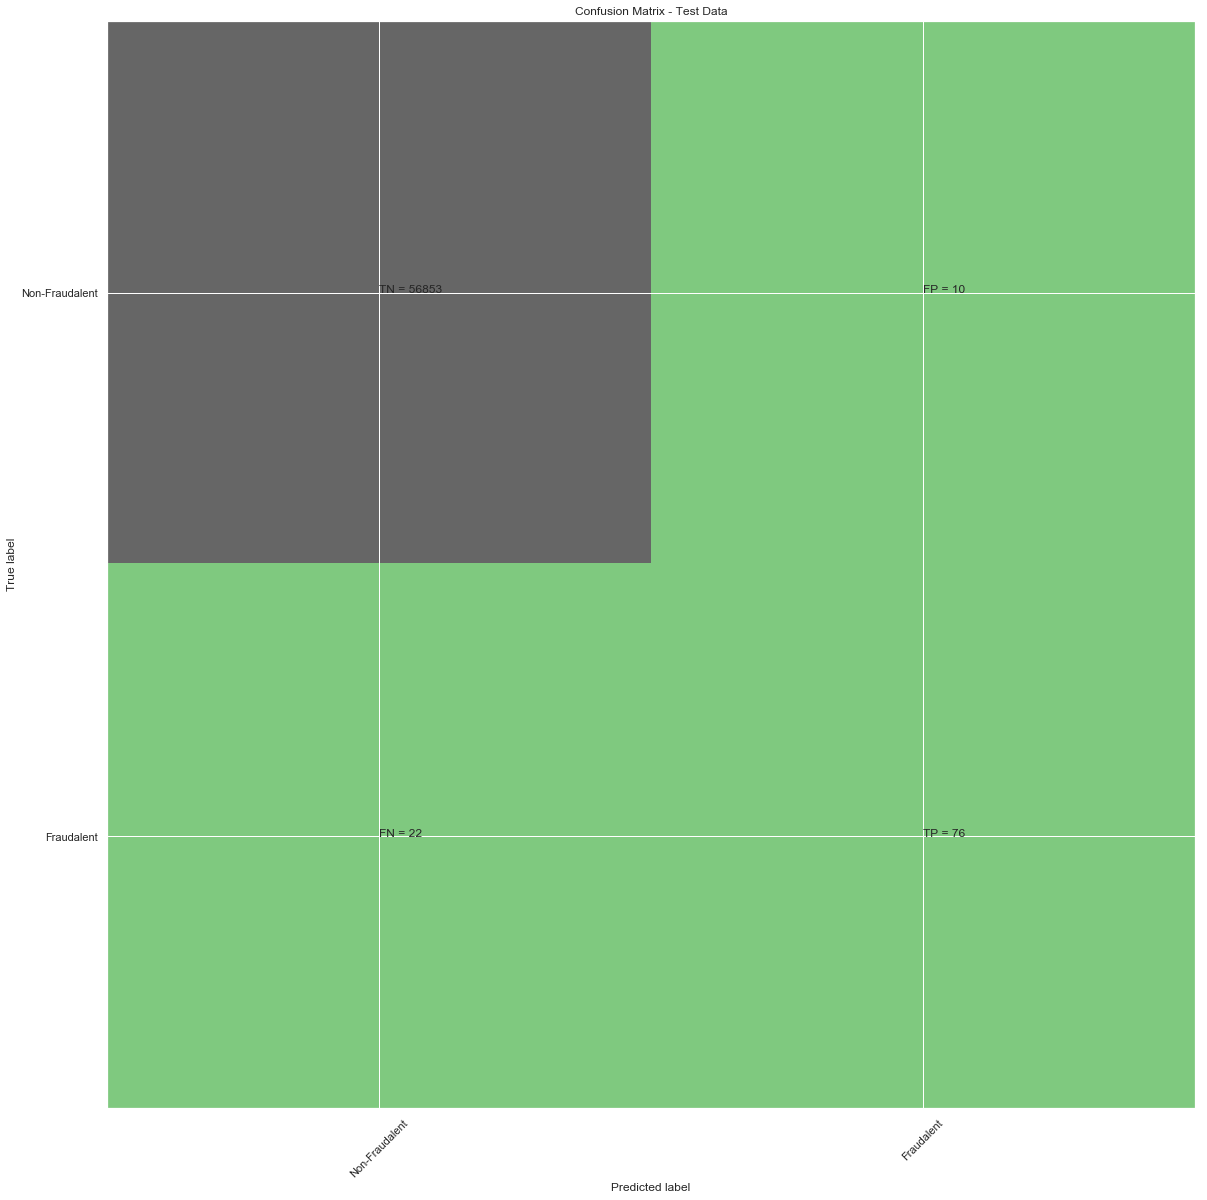

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9741530574560336
XGBoost threshold: 0.00022058551257941872
ROC for the test dataset 97.4%


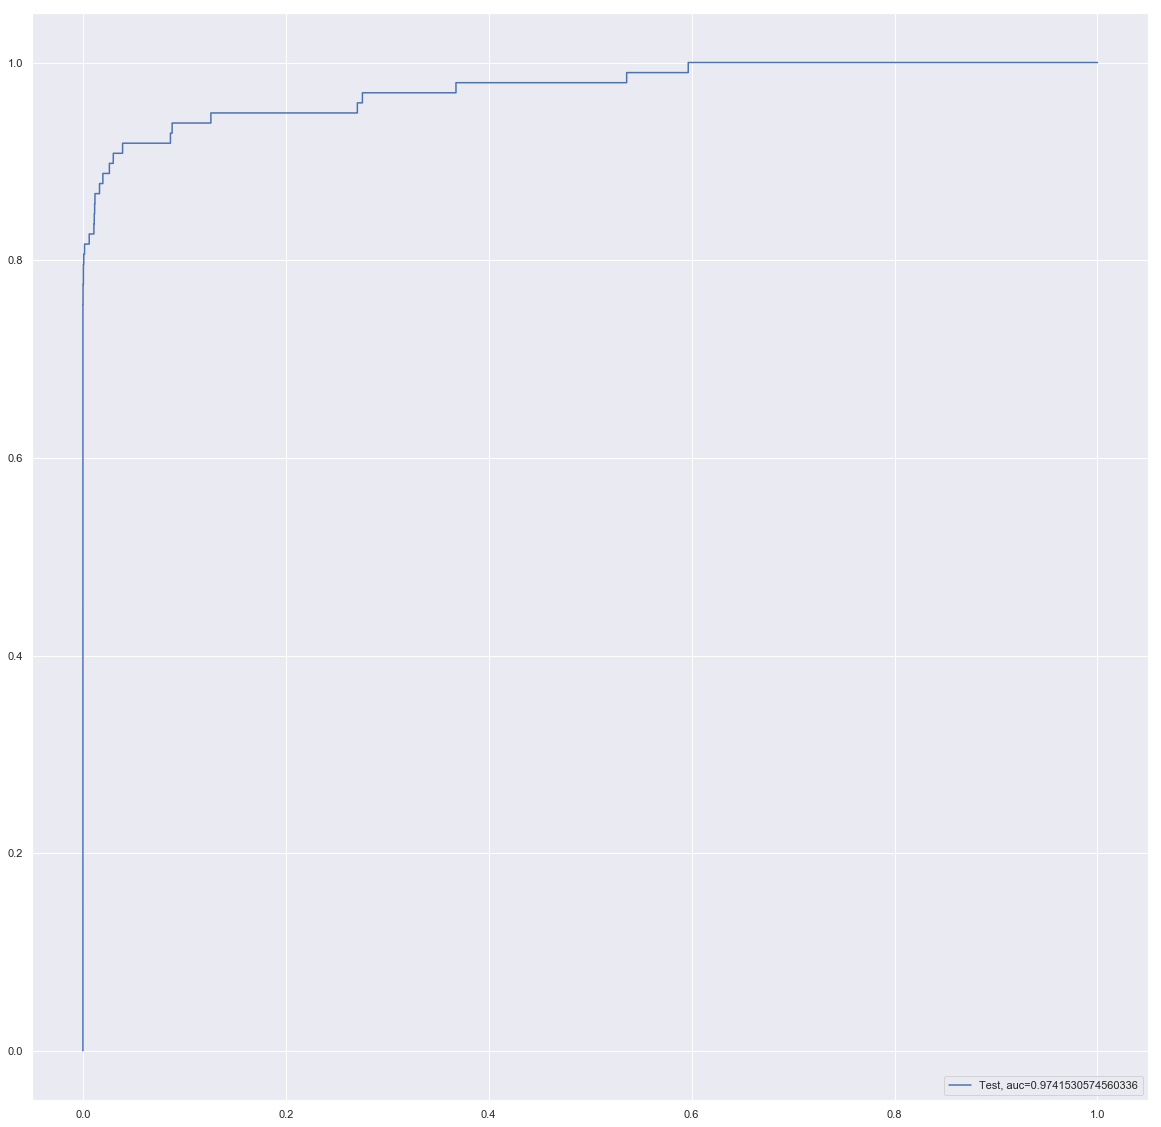

Time Taken by Model: --- 113.97311878204346 seconds ---
--------------------------------------------------------------------------------


In [122]:
Data_Imbalance_Handiling_label	 = "SMOTE Oversampling with StratifiedKFold CV "
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_train_Smote, y_train_Smote , X_test, y_test)

In [123]:

df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071
6,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.988648,0.002194
7,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999122,0.881087,0.053797
8,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999210,0.886886,1.000000
9,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.903024,1.000000


## Observation:
Results for Random Oversampling: Random Oversampling seems to have +ve change in prediction for XGBoost Looking at Accuracy and ROC value we have XGBoost which has provided best results for SMOTE oversampling technique.

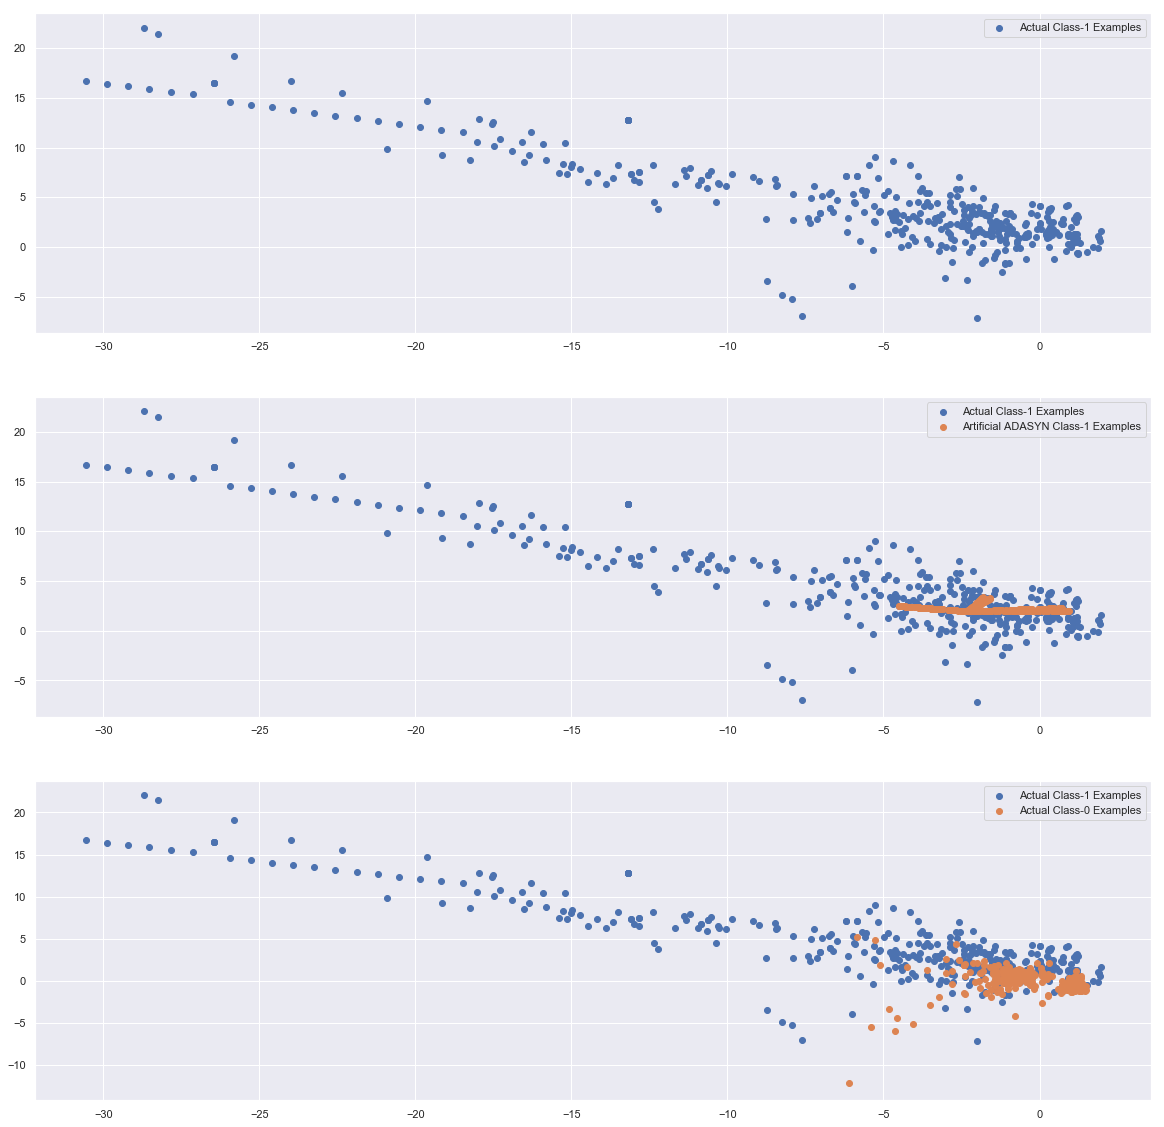

In [124]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ADASYN = over_sampling.ADASYN(random_state=0)
X_train_ADASYN, y_train_ADASYN = ADASYN.fit_resample(X_train, y_train) 

# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_ADASYN[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1.iloc[:X_train_1.shape[0], 0], X_train_adasyn_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [125]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_ADASYN, y_train_ADASYN= ADASYN.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN,   columns=cols)

Build models on other algorithms to see the better performing on ADASYN

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9835152822069089
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.99352431  1.05890425  0.87006896  0.95057811  0.76688493 -1.20191373
  -0.94508892 -0.58477926 -0.36215818 -0.8870304   0.7927145  -1.45290871
  -0.16496652 -1.99222037  0.14390894 -1.00116806 -1.14671523 -0.52911152
   0.38428502 -1.41617718 -0.20505488  0.71906059  0.65737902 -1.11488357
   0.71552194  0.20913918  0.15098938  1.33036217  0.01285269  0.02233856]]
[-5.1187591]
{1: array([[0.610404  , 0.63191849, 0.72150467, 0.87081578, 0.95798817,
        0.97416661, 0.97844939, 0.9814836 , 0.98277346, 0.98315473,
        0.98321757, 0.98321847, 0.98321847, 0.98321847, 0.98321847,
        0.98321847, 0.98321847, 0.98321847, 0.98321847, 0.98321847],
       [0.61072194, 0.63192858, 0.72000917, 0.86805623, 0.95677094,
        0.9739103 , 0.9785645 , 0.98179919, 0.98313277, 0.98350409,
        0.98355784, 0.98355784, 0.98355784, 0.98355784,

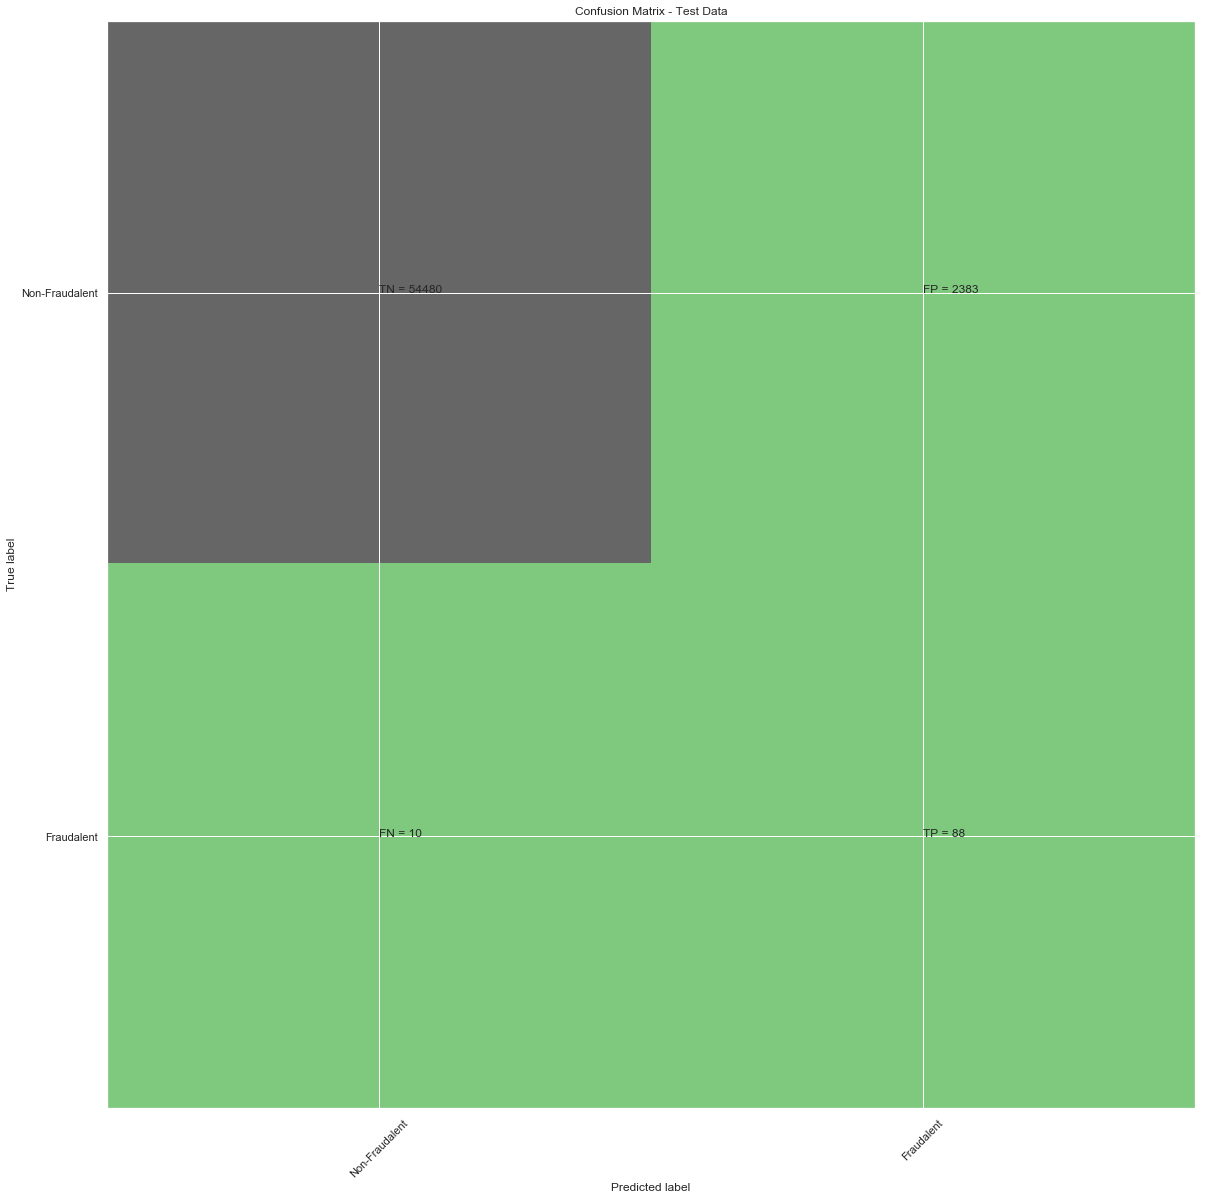

classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.93      0.52     56961
weighted avg       1.00      0.96      0.98     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


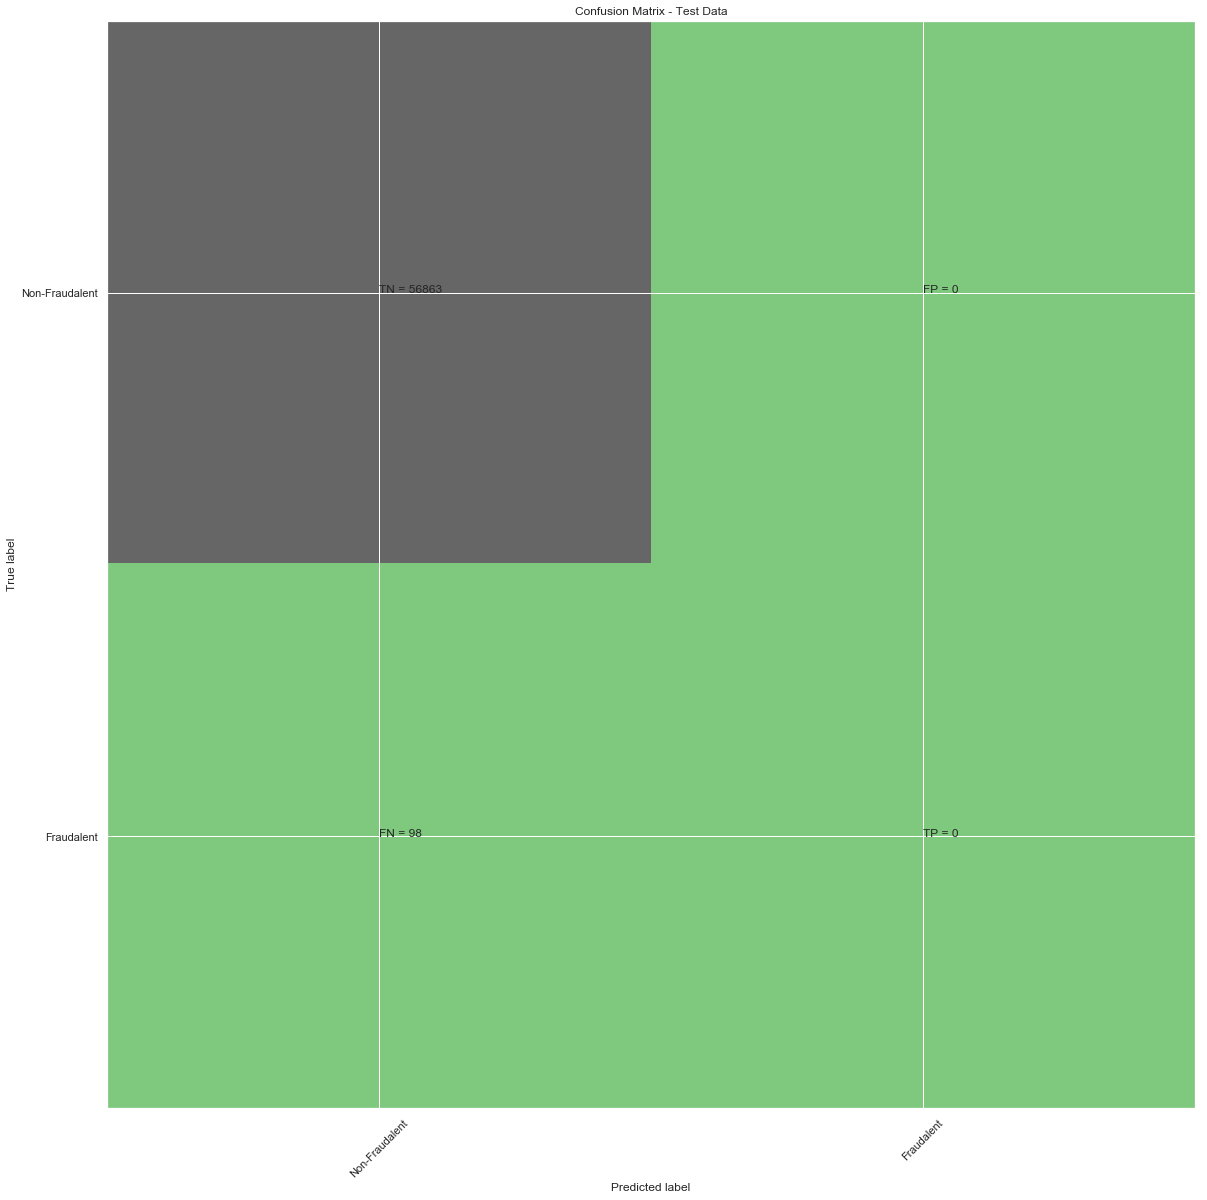

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9740295059338826
l2 threshold: 0.611606199519744
ROC for the test dataset 97.4%


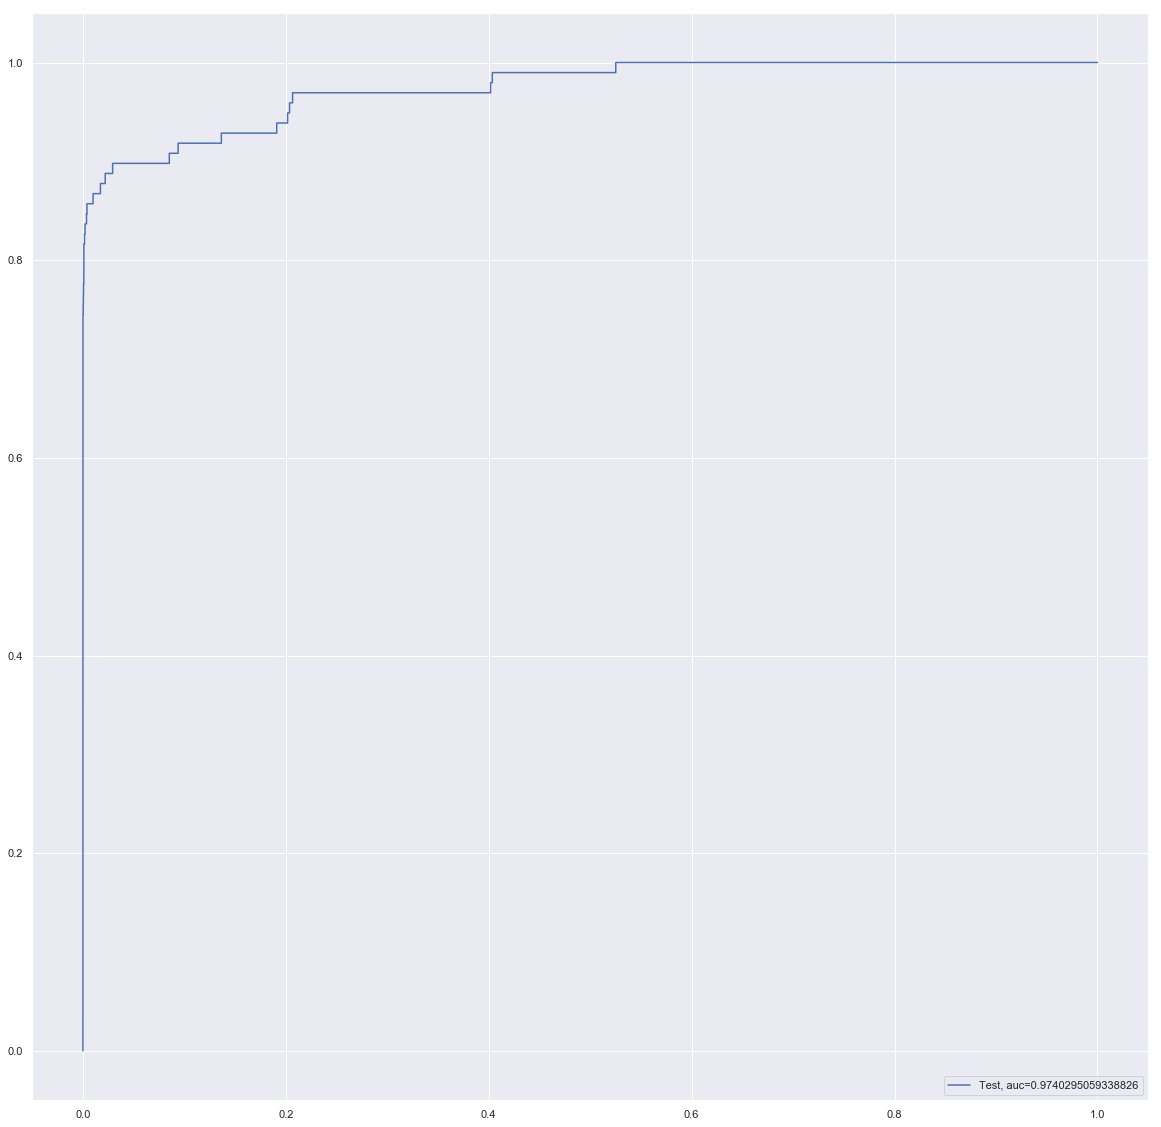

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


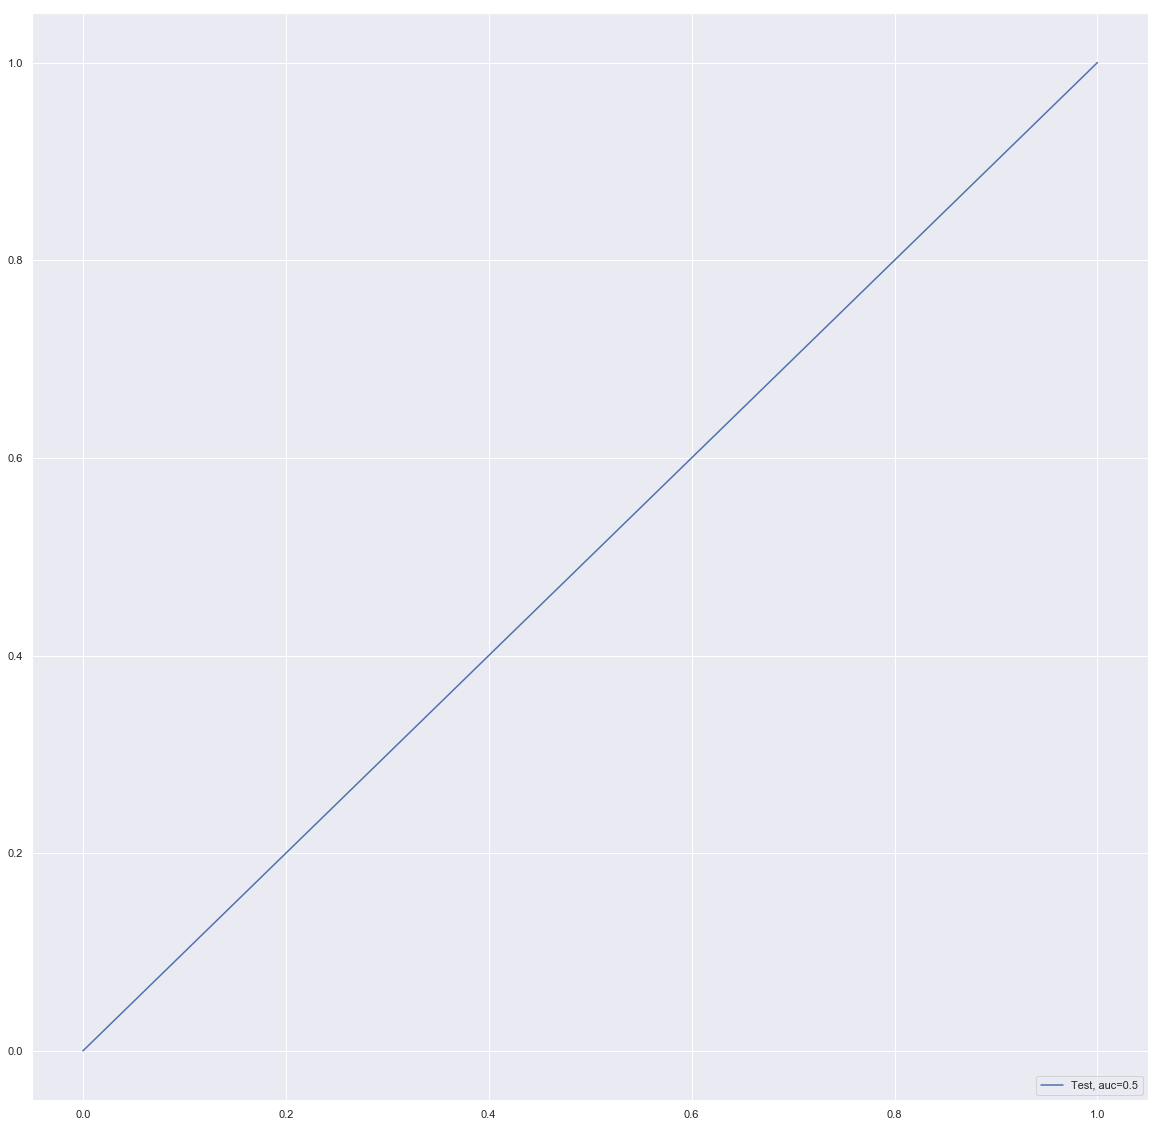

Time Taken by Model: --- 609.3913495540619 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9979459630273345
Confusion Matrix


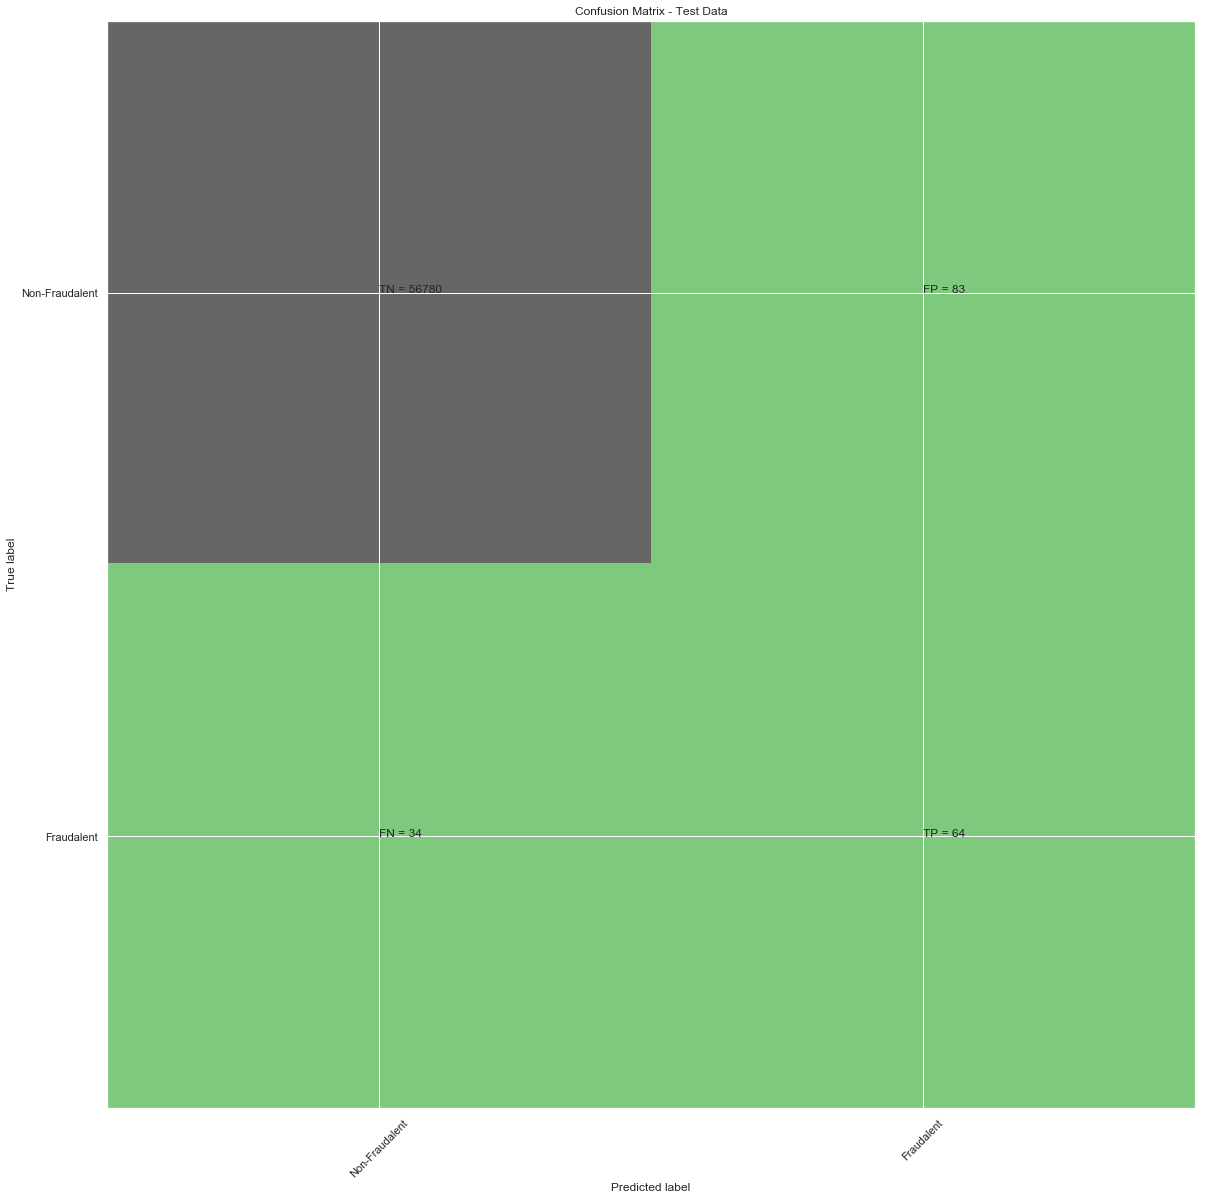

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8258007879303172
Tree threshold: 1.0
ROC for the test dataset 82.6%


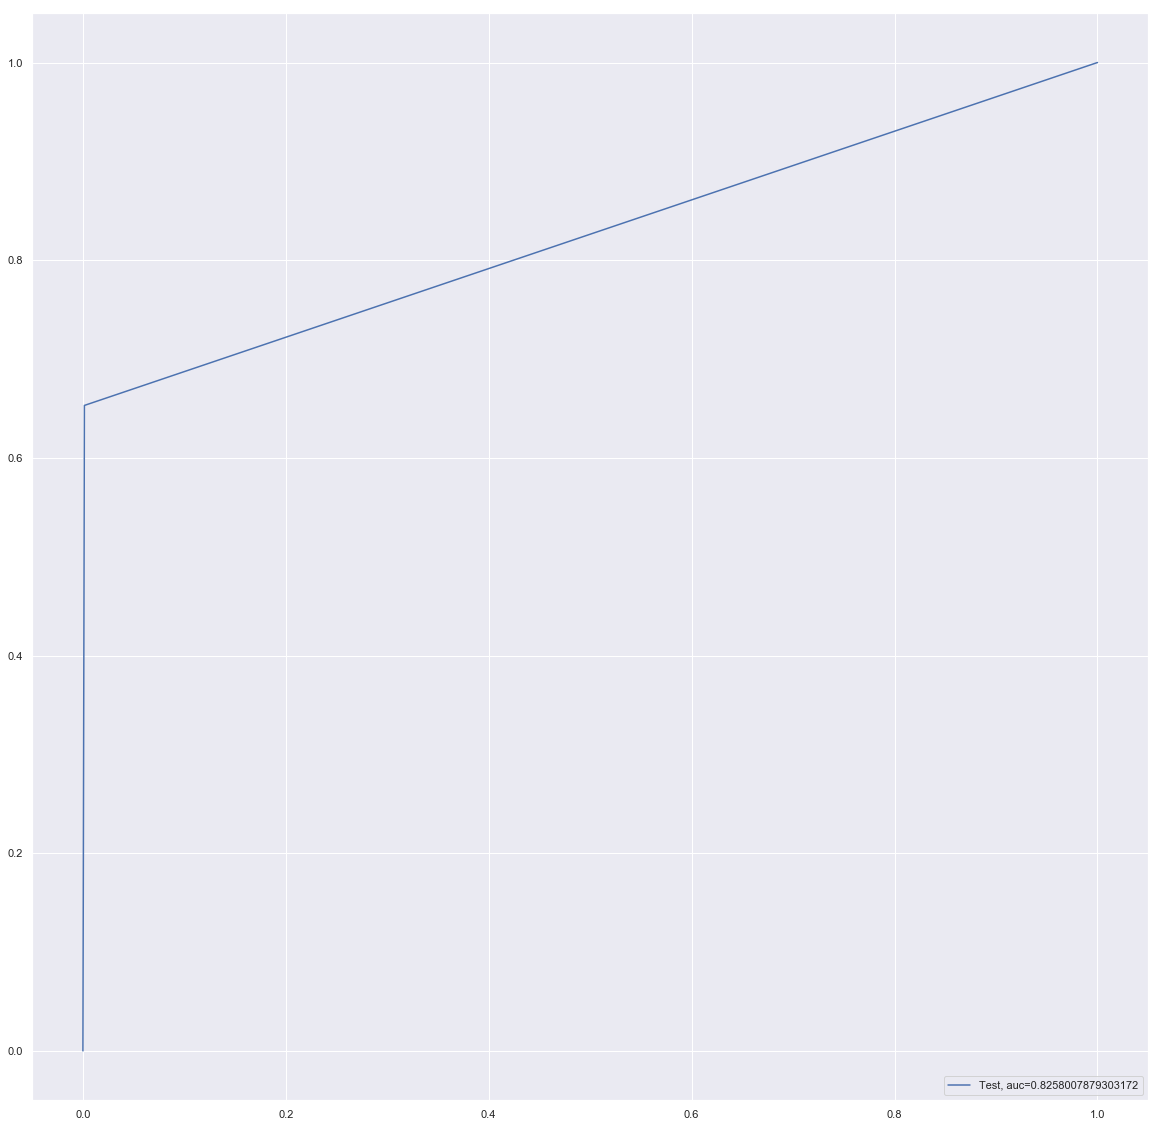

entropy score: 0.9954179175225154
Confusion Matrix


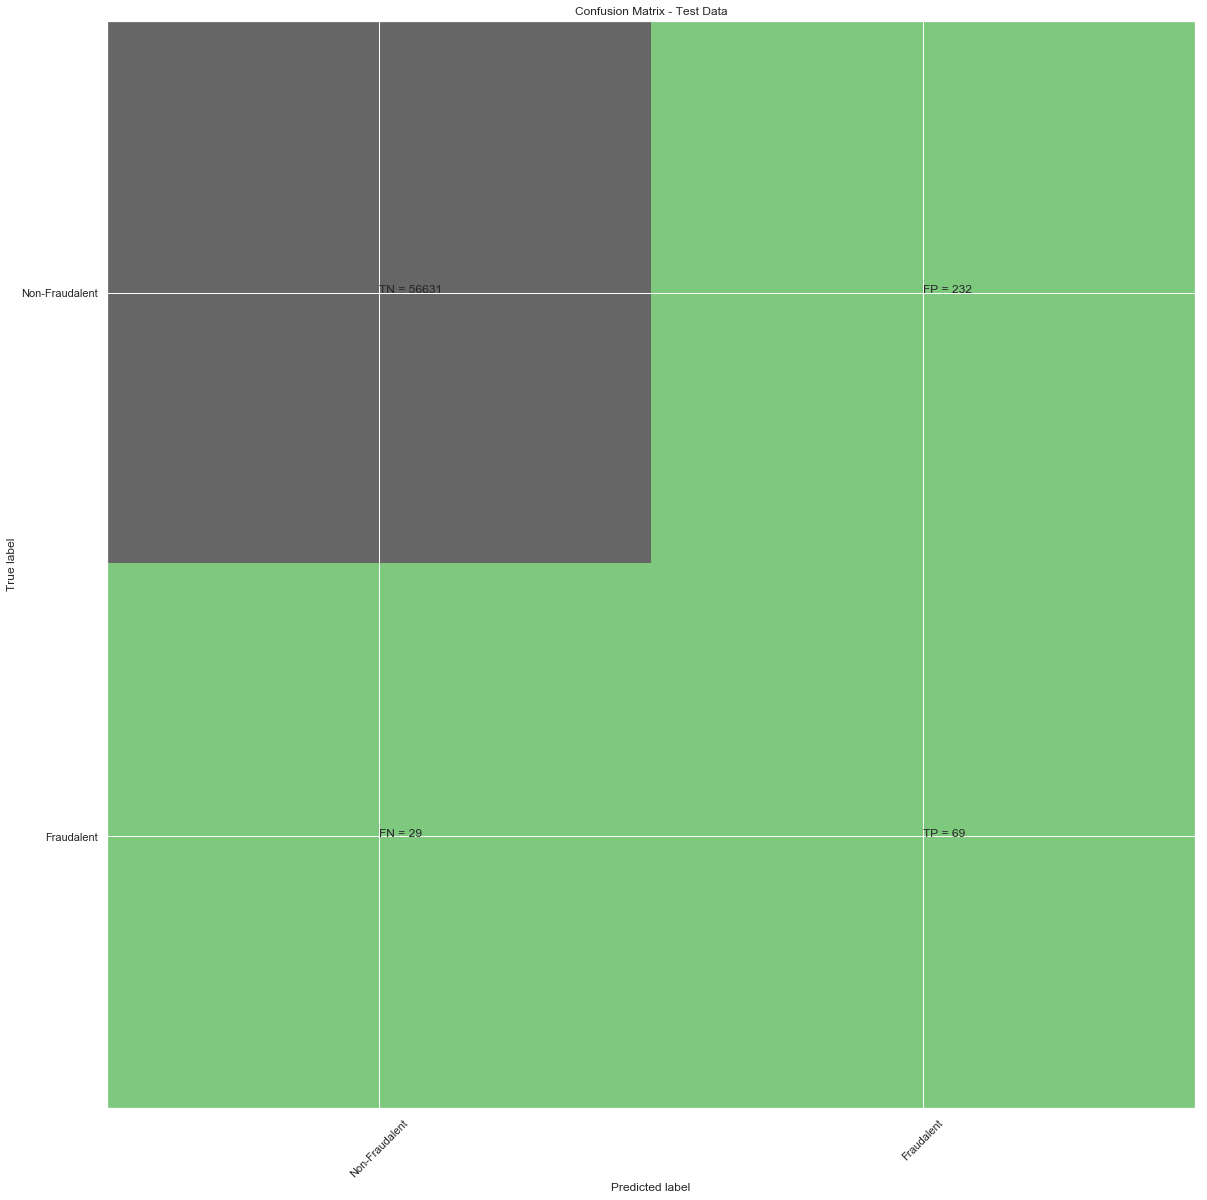

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8500008254713172
Tree threshold: 1.0
ROC for the test dataset 85.0%


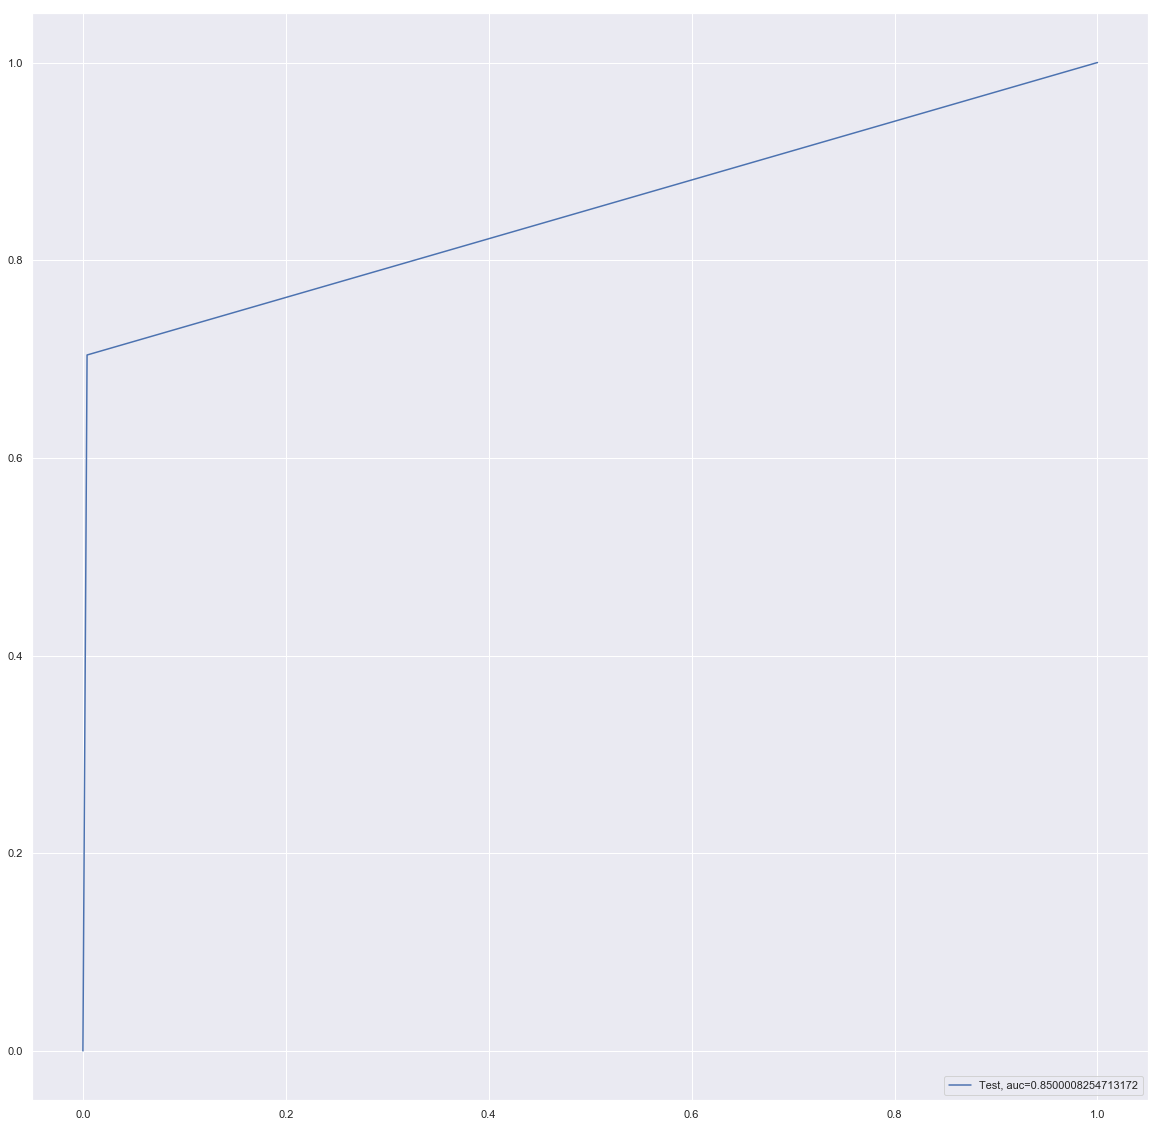

Time Taken by Model: --- 66.85569286346436 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


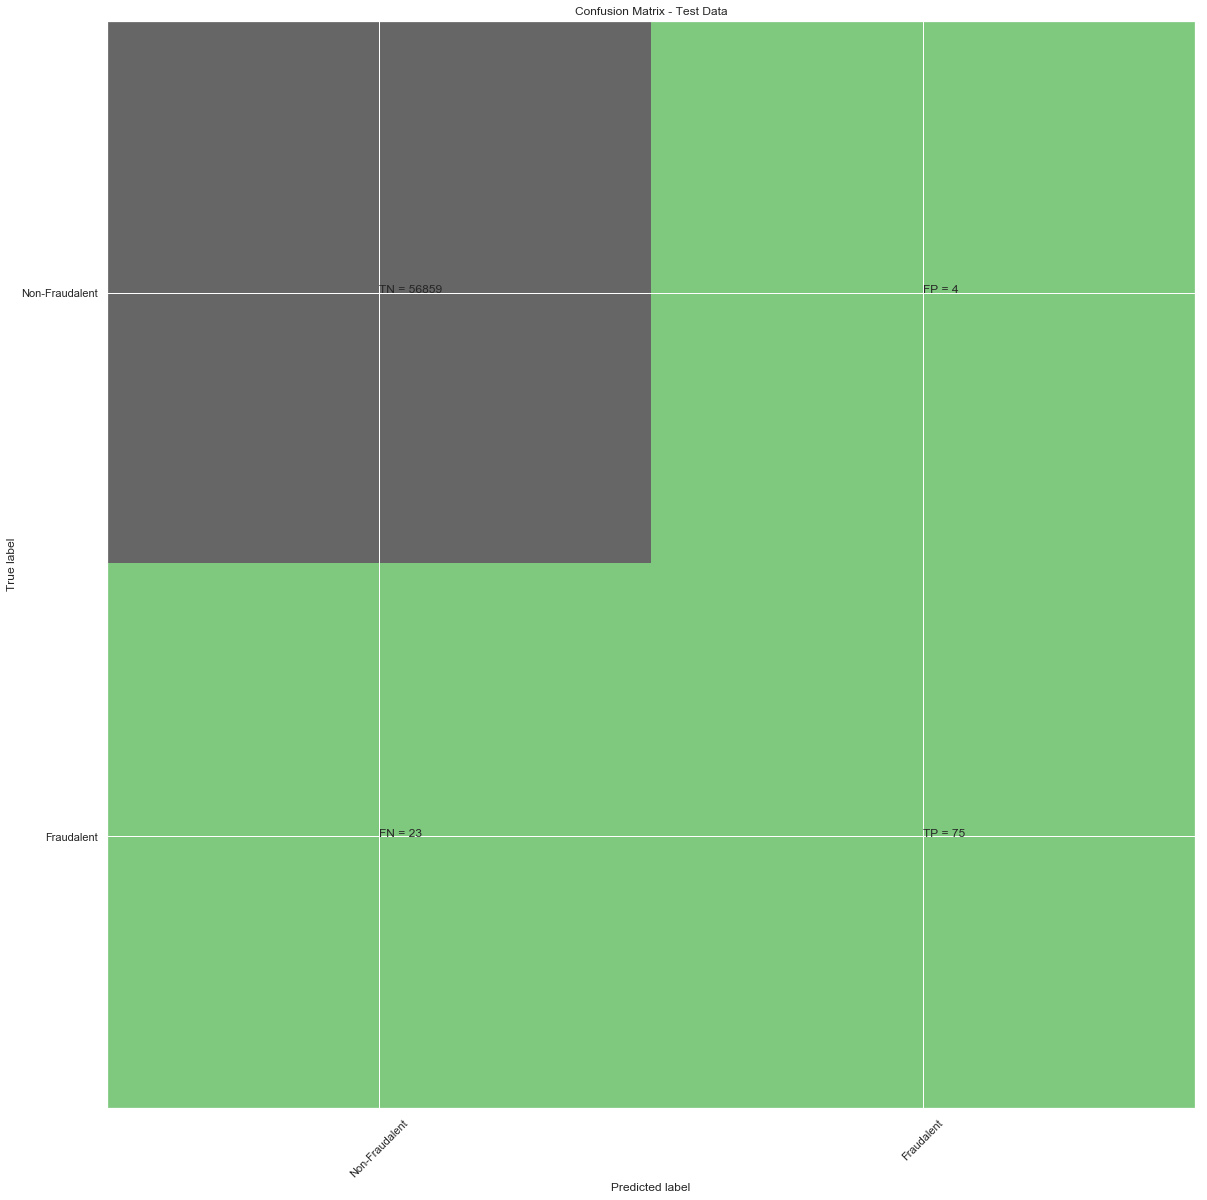

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9632269575962563
Random Forest threshold: 0.03
ROC for the test dataset 96.3%


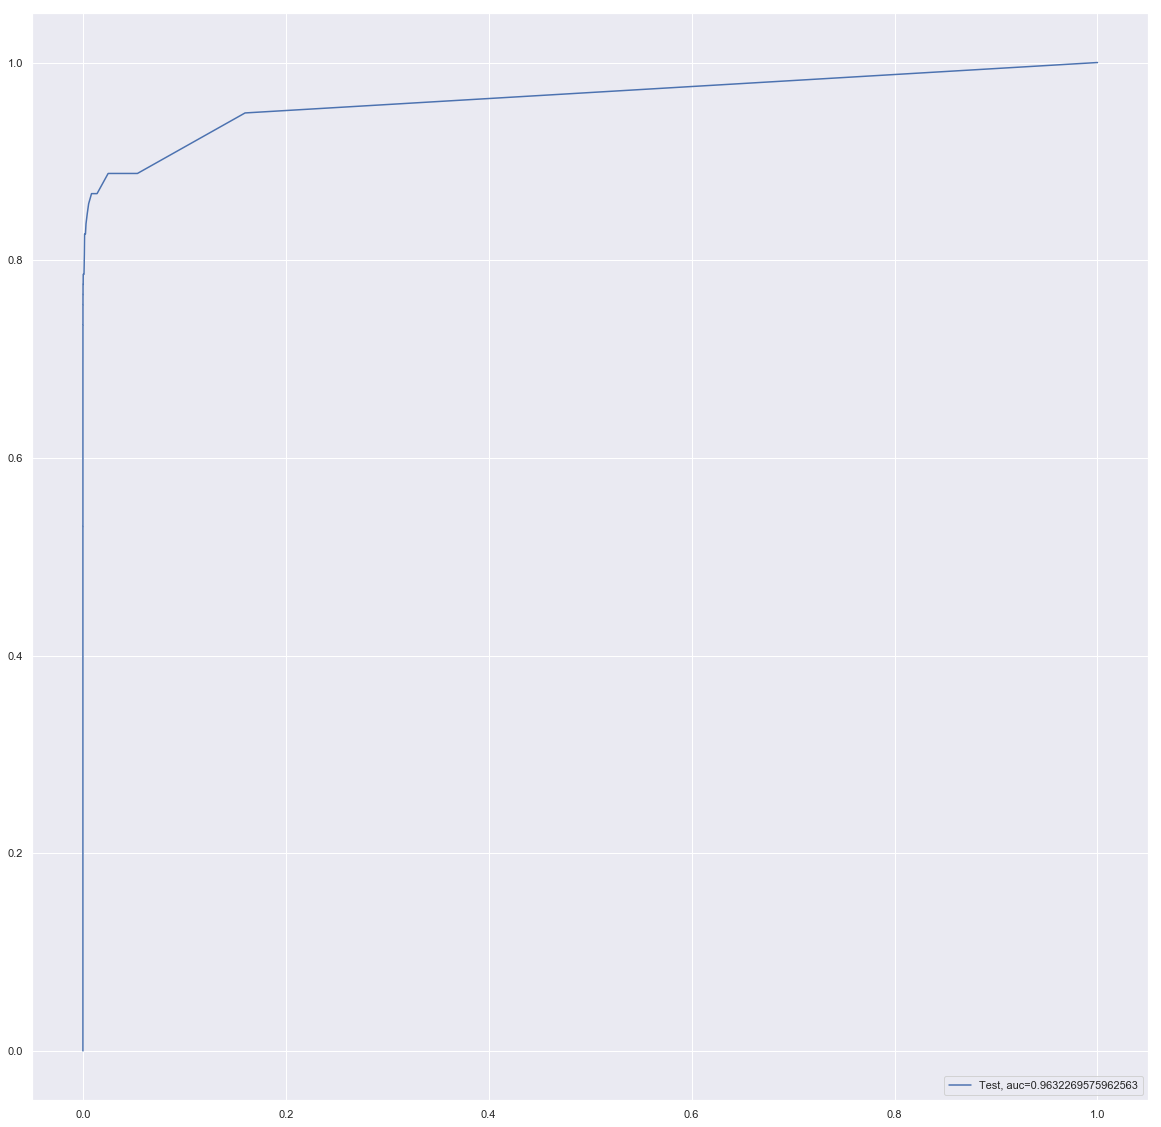

Time Taken by Model: --- 322.00651025772095 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9993855444953564
Confusion Matrix


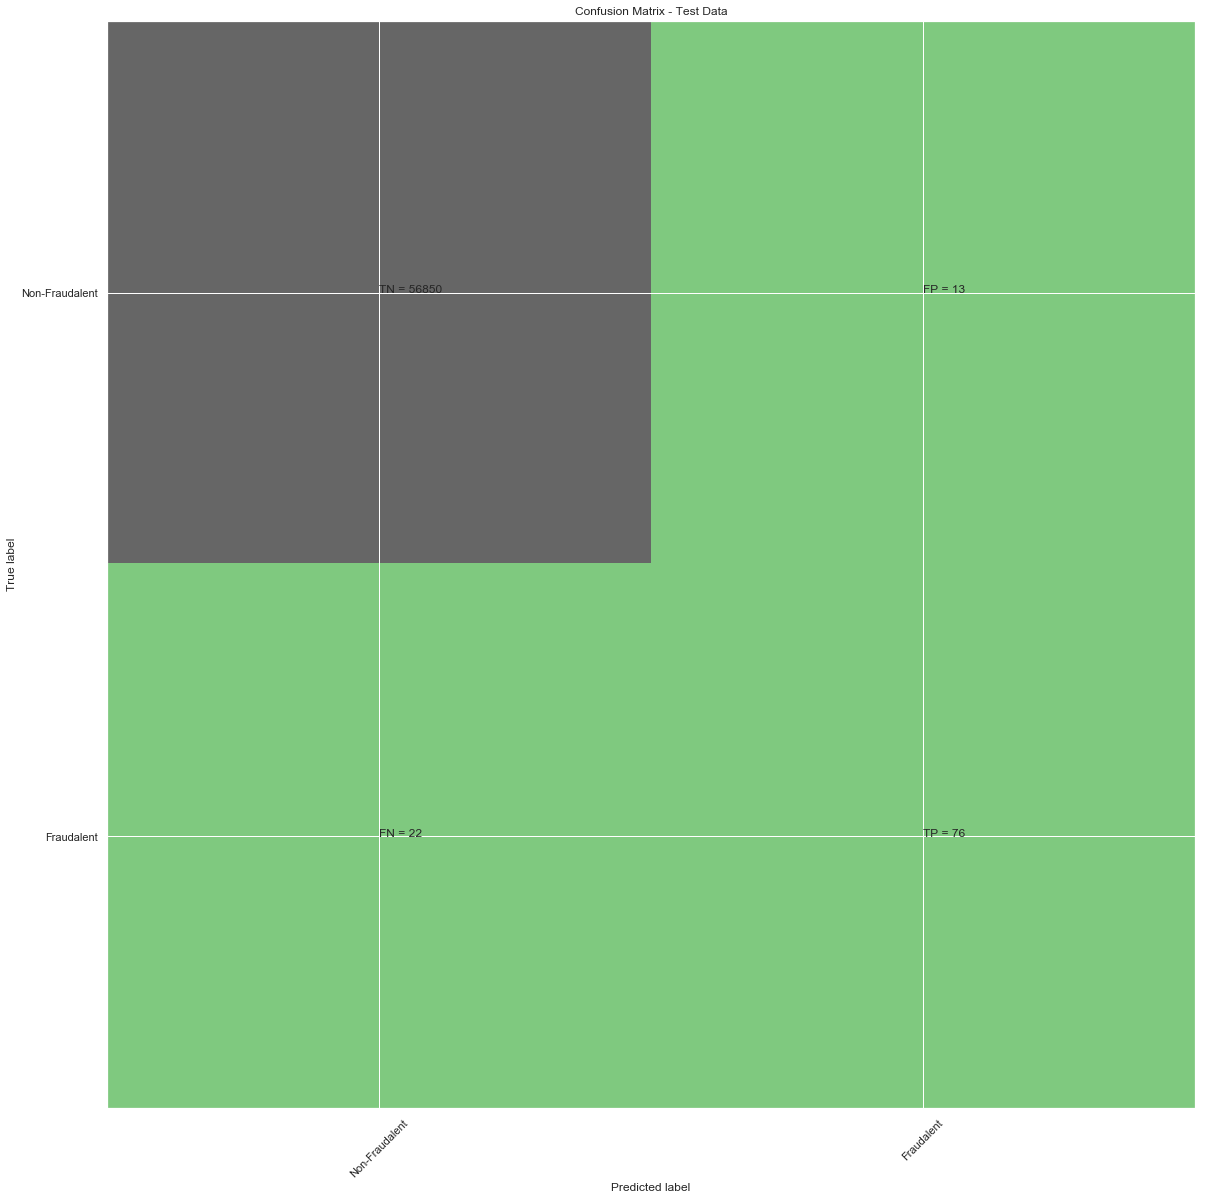

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.78      0.81        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.970320537690482
XGBoost threshold: 0.0016991241136565804
ROC for the test dataset 97.0%


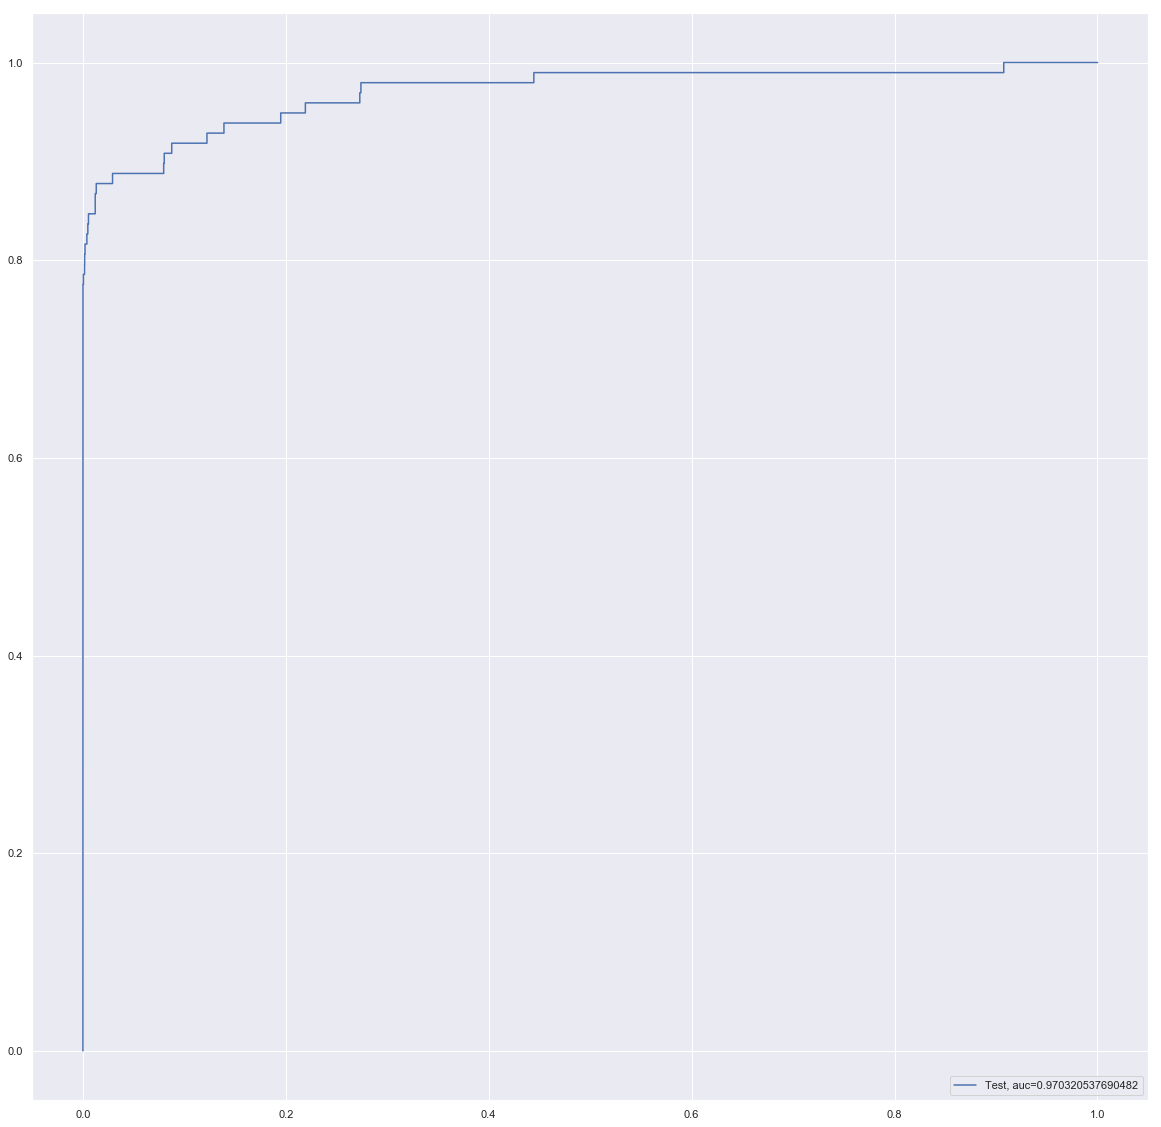

Time Taken by Model: --- 123.62753415107727 seconds ---
--------------------------------------------------------------------------------


In [126]:
Data_Imbalance_Handiling_label	 = "ADASYN Oversampling with StratifiedKFold CV "
df_Results = RunAllSelectedModels(df_Results,Data_Imbalance_Handiling_label,X_train_ADASYN, y_train_ADASYN , X_test, y_test)

In [134]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999105,0.981664,0.003509
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999070,0.928705,0.022458
2,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
4,Power Transformer,Random Forest,0.999561,0.962753,0.010000
5,Power Transformer,XGBoost,0.999614,0.982308,0.000071
6,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.988648,0.002194
7,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999122,0.881087,0.053797
8,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999210,0.886886,1.000000
9,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.903024,1.000000


## Observation
Results for ADASYN Oversampling:
Looking at Accuracy and ROC value we have XGBoost which has provided best results for ADASYN oversampling technique

Overall conclusion after running models on Oversampled data:
Looking at above results it seems XGBOOST model with Random Oversampling with StratifiedKFold CV has provided best results. So we can try to tune the hyperparameters of this model to get best results

But looking at the results Logistic Regression with L2 Regularisation with RepeatedKFold Cross Validation has been provided best results without any oversampling.
Parameter Tuning for Final Model by Handling class imbalance

In [128]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(random_state=42)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.999490879724724
XGboost roc_value: 0.9734122866739858
XGBoost threshold: 0.0010864053620025516


In [146]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(random_state=42)

In [147]:
#Lets tune XGBoost Model for max_depth and min_child_weight
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([175.71683984, 162.58653059, 168.4051127 , 268.50032048,
         265.86625557, 267.18432431, 363.51059346, 359.37586489,
         353.44930477, 437.01313009, 427.93705769, 390.93713541]),
  'std_fit_time': array([ 9.21339602,  8.24647977,  3.22414252,  1.93536145,  1.64553327,
          1.45894068,  2.98054294,  4.10393495,  2.57926177,  5.0106763 ,
          2.32479508, 33.81514471]),
  'mean_score_time': array([0.35835423, 0.3235033 , 0.31316328, 0.42905178, 0.40211849,
         0.43678026, 0.53457179, 0.53776221, 0.54494362, 0.61874528,
         0.63211007, 0.52839475]),
  'std_score_time': array([0.05674737, 0.01467083, 0.0073022 , 0.02197372, 0.00634818,
         0.02878389, 0.01333341, 0.01541727, 0.02466177, 0.0339371 ,
         0.05988399, 0.11960244]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [148]:
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'n_estimators':range(60,150,20)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([100.04988599, 132.01436944, 167.8410953 , 194.57385082,
         208.81085258]),
  'std_fit_time': array([ 1.11743091,  2.23933308,  3.53199279,  0.36514739, 25.17441758]),
  'mean_score_time': array([0.28004894, 0.32792287, 0.31714969, 0.36062574, 0.31928229]),
  'std_score_time': array([0.01327633, 0.02675478, 0.01136719, 0.02695225, 0.06010155]),
  'param_n_estimators': masked_array(data=[60, 80, 100, 120, 140],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 60},
   {'n_estimators': 80},
   {'n_estimators': 100},
   {'n_estimators': 120},
   {'n_estimators': 140}],
  'split0_test_score': array([0.99821857, 0.9990428 , 0.99923075, 0.9993499 , 0.99939038]),
  'split1_test_score': array([0.99931561, 0.99966203, 0.99979168, 0.99990576, 0.99994503]),
  'split2_test_score': array([0.99541453, 0.99742756, 0.99843732, 0.99900568, 0.99906991]),
  'split3_test_score': array(

In [149]:
# We will narror down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'n_estimators':[110,120,130],
  'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=1, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([127.01881599, 140.57218032, 150.36151023, 123.36934953,
         130.4633678 , 141.56164889, 121.81995296, 130.90603876,
         139.90161991, 174.57486014, 179.1089891 , 186.91081495,
         159.81097655, 173.71728082, 186.22373319, 159.55594821,
         171.88640943, 186.43981681, 210.8380075 , 228.29945807,
         248.93244166, 209.21359859, 229.69921055, 246.04706411,
         210.80981941, 228.68084664, 229.5129436 ]),
  'std_fit_time': array([ 2.39471598,  2.44729205,  1.16569521,  2.69150383,  0.49780333,
          0.33626415,  2.05114397,  1.52114467,  0.20593671,  1.65076054,
          5.30177055,  0.72302398,  1.19834165,  0.59046599,  0.78563081,
          1.29298751,  0.5871251 ,  0.6988073 ,  1.30459498,  1.30707667,
          0.81680933,  1.09244591,  1.25594093,  0.57428293,  1.19664096,
          0.86335272, 23.61801692]),
  'mean_score_time': array([0.05406528, 0.01849751, 0.02496624, 0.02699776, 0.0293992 ,
         0.02862864, 0.023554

In [150]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 parameters tuned above we will now check learning rate

# We will narror down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'learning_rate':[0.05,0.1,0.125,0.15,0.2]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 245.43907785,  247.38628321, 2466.51886106, 1051.93383279,
          255.86681027]),
  'std_fit_time': array([2.45916265e+00, 1.56635559e+00, 1.81354085e+03, 1.44743665e+03,
         4.52709775e+01]),
  'mean_score_time': array([0.02057576, 0.01351991, 0.02785835, 0.02581468, 0.01818433]),
  'std_score_time': array([0.00728573, 0.0042084 , 0.00700368, 0.02691961, 0.01051698]),
  'param_learning_rate': masked_array(data=[0.05, 0.1, 0.125, 0.15, 0.2],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.05},
   {'learning_rate': 0.1},
   {'learning_rate': 0.125},
   {'learning_rate': 0.15},
   {'learning_rate': 0.2}],
  'split0_test_score': array([nan, nan, nan, nan, nan]),
  'split1_test_score': array([nan, nan, nan, nan, nan]),
  'split2_test_score': array([nan, nan, nan, nan, nan]),
  'split3_test_score': array([nan, nan, nan, nan, nan]),
  'split4_test_score': array([

In [138]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 parameters tuned above we will now check learning rate

# We will narror down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([278.75639658, 274.98434935, 277.27016678, 272.62771544,
         245.25220213]),
  'std_fit_time': array([ 2.41464191,  1.65105796,  0.50973869,  2.50059573, 46.95079357]),
  'mean_score_time': array([0.03610902, 0.02433681, 0.02294178, 0.02153835, 0.02235203]),
  'std_score_time': array([0.01772058, 0.00292889, 0.00399325, 0.00186601, 0.00494044]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([nan, nan, nan, nan, nan]),
  'split1_test_score': array([nan, nan, nan, nan, nan]),
  'split2_test_score': array([nan, nan, nan, nan, nan]),
  'split3_test_score': array([nan, nan, nan, nan, nan]),
  'split4_test_score': array([nan, nan, nan, nan, nan]),
  'mean_test_score': array([nan, nan, nan, nan, nan]),
  '

In [151]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.999420656238479
XGboost roc_value: 0.9793574746607223
XGBoost threshold: 0.004121198318898678


In [152]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 , gamma: 0.1 parameters tuned above we will now check learning rate

# We will narror down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'subsample':[i/10.0 for i in range(7,10)],
 'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 183.56121392,  179.82583876,  196.93175869,  201.10826406,
         5074.5003603 , 4671.1158318 ,  210.90489635,  214.57849956,
          210.70429406]),
  'std_fit_time': array([8.27324601e+00, 4.61280515e+00, 1.86344157e+00, 4.65070940e+00,
         1.27752524e+03, 3.63507081e+03, 7.27825362e+00, 1.84777362e+00,
         3.33456836e+01]),
  'mean_score_time': array([0.05277877, 0.02269006, 0.02566023, 0.02082615, 0.02299976,
         0.01764154, 0.02476897, 0.01806207, 0.02187262]),
  'std_score_time': array([0.024407  , 0.00602649, 0.00577621, 0.00761969, 0.00860411,
         0.00712453, 0.00747686, 0.01147467, 0.00766216]),
  'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9, 0.7, 0.8, 0.9]

In [153]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.9994557679816014
XGboost roc_value: 0.980778272302889
XGBoost threshold: 0.003258659038692713


## Observations:
As the roc value has dropped we will take not consider new values of colsample_bytree': 0.8, 'subsample': 0.8

In [154]:
# perform the best oversampling method on X_train & y_train

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=1, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
clf.fit(X_over, y_over ) # fit on the balanced dataset
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.999420656238479
XGboost roc_value: 0.9793574746607223
XGBoost threshold: 0.004121198318898678


## Print the important features of the best model to understand the dataset

Top var = 14
2nd Top var = 10
3rd Top var = 12


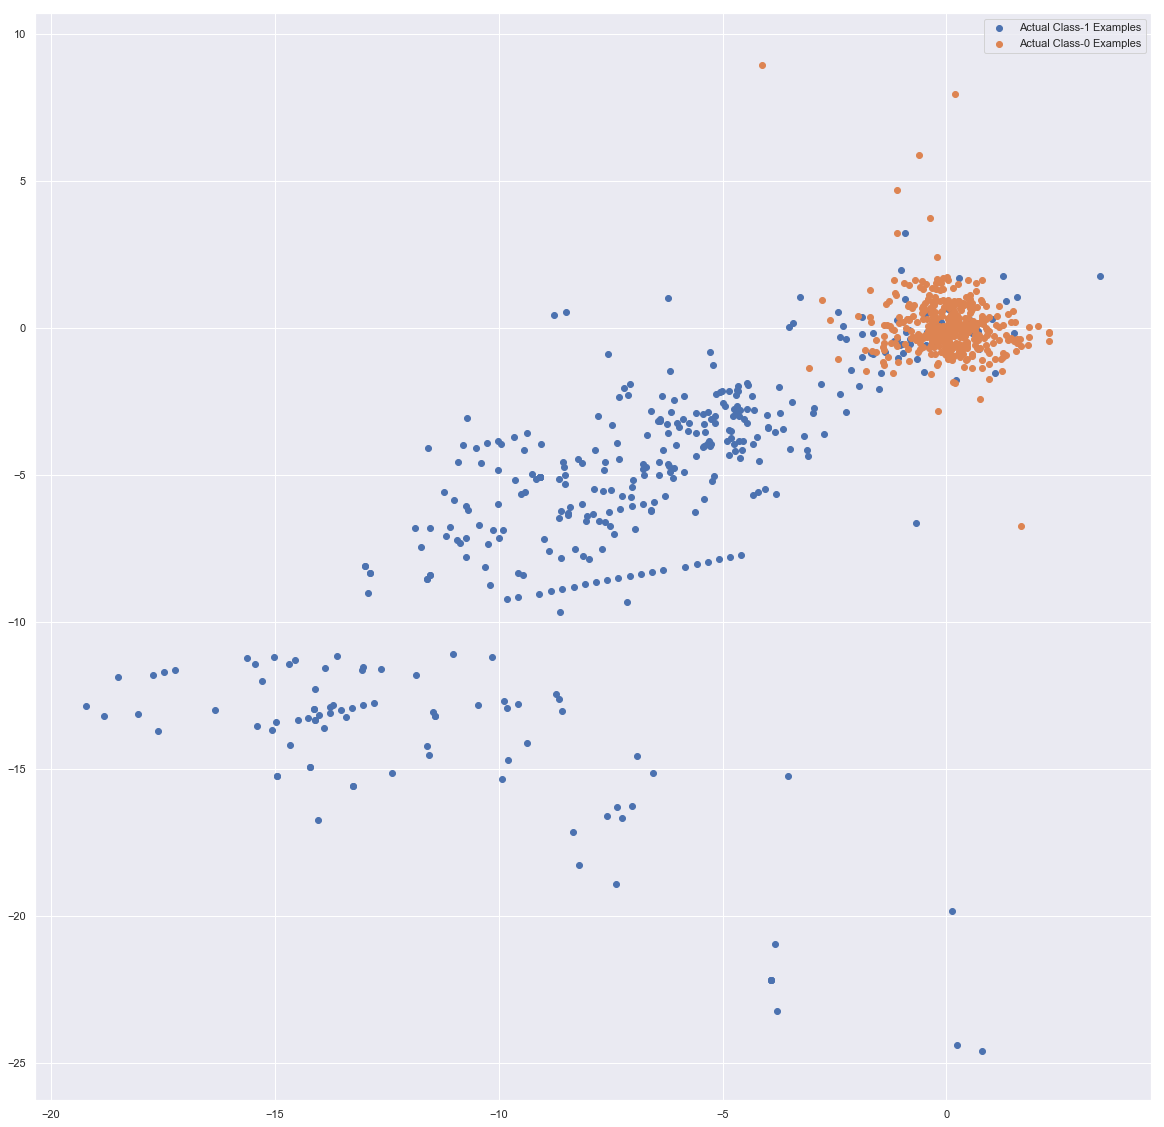

In [143]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [145]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

XGboost roc_value: 0.9734122866739858
XGBoost threshold: 0.0010864053620025516


## Model Selection:
Overall conclusion after running models on Oversampled data:
Looking at above results it seems XGBOOST model with Random Oversampling with StratifiedKFold CV has provided best results. So we can try to tune the hyperparameters of this model to get best results

We have selected XGBOOST model with Random Oversampling and StratifiedKFold CV

Model Accuracy: 0.999420656238479

XGboost roc_value: 00.9734122866739858

XGBoost threshold: 0.0010864053620025516

We also noticed by looking at the results Logistic Regression with L2 Regularisation with RepeatedKFold Cross Validation has been provided best results without any oversampling.

## Summary to the business
For banks with smaller average transaction value, we would want high precision because we only want to label relevant transactions as fraudulent. For every transaction that is flagged as fraudulent, we can add the human element to verify whether the transaction was done by calling the customer. However, when precision is low, such tasks are a burden because the human element has to be increased.

For banks having a larger transaction value, if the recall is low, i.e., it is unable to detect transactions that are labelled as non-fraudulent. So we have to consider the losses if the missed transaction was a high-value fraudulent one.

So here, to save the banks from high-value fraudulent transactions, we have to focus on a high recall in order to detect actual fraudulent transactions.

After performing several models, we have seen that in the balanced dataset with SMOTE technique the simplest Logistic regression model has good ROC score and also high Recall. Hence, we can go with the logistic model here. It is also easier to interpret and explain to the business.